In [5]:
################Multi-stage sleep classification using photoplethysmographic sensor#################


In [8]:
import pandas as pd
from scipy.signal import savgol_filter

# Define the file names for the 10 subjects
file_names = ['AHI11.2-1Hypno.txt', 'AHI11.2-1Pleth.txt',
              'AHI16.2-1Hypno.txt', 'AHI16.2-1Pleth.txt',
              'AHI17.3Hypno.txt', 'AHI17.3Pleth.txt', 'AHI18.4Hypno.txt', 'AHI18.4Pleth.txt',
              'AHI19.2Hypno.txt', 'AHI19.2Pleth.txt', 'AHI20.8Hypno.txt', 'AHI20.8Pleth.txt',
              'AHI22.1Hypno.txt', 'AHI22.1Pleth.txt', 'AHI28.3Hypno.txt', 'AHI28.3Pleth.txt',
              'AHI52.5Hypno.txt', 'AHI52.5Pleth.txt', 'AHI68.7Hypno.txt', 'AHI68.7Pleth.txt']

# Load and preprocess data for each subject
for i in range(0, len(file_names), 2):
    # Load hypnogram data
    hypno_data = pd.read_csv(file_names[i], sep='\t', header=None, names=['hypno'])
    # Load PPG signal data, skipping the first row
    pleth_data = pd.read_csv(file_names[i+1], sep='\t', header=None, names=['pleth'], dtype={0: float}, skiprows=1)

    # Preprocessing
    # Baseline Correction
    baseline = pleth_data['pleth'].iloc[0]  # Assuming the baseline is the first value of the signal
    pleth_data['pleth'] -= baseline

    # Apply Savitzky-Golay filtering
    order = 3
    frame_size = 9
    pleth_data['pleth_filtered'] = savgol_filter(pleth_data['pleth'], window_length=frame_size, polyorder=order)

    # Apply z-score normalization
    pleth_data['pleth_filtered'] = (pleth_data['pleth_filtered'] - pleth_data['pleth_filtered'].mean()) / pleth_data['pleth_filtered'].std()

    # Segment the data into 30-second non-overlapping epochs
    epoch_duration = 30  # seconds
    sampling_frequency = 128  # Hz
    samples_per_epoch = epoch_duration * sampling_frequency
    total_epochs = len(pleth_data) // samples_per_epoch
    epochs = [pleth_data.iloc[i * samples_per_epoch:(i + 1) * samples_per_epoch] for i in range(total_epochs)]

    # Merge LS and DS for three-stage classification, and NREM and REM for binary sleep-wake classification
    for epoch in epochs:
        epoch['sleep_stage'] = epoch['hypno'].map({'W': 'awake', 'R': 'REM', '1': 'light sleep', '2': 'light sleep',
                                                    '3': 'deep sleep', '4': 'deep sleep'})

        # Merge LS and DS for three-stage classification
        epoch['sleep_stage_3class'] = epoch['sleep_stage'].replace({'light sleep': 'NREM', 'deep sleep': 'NREM'})

        # Merge NREM and REM for binary sleep-wake classification
        epoch['sleep_wake'] = epoch['sleep_stage'].replace({'awake': 'awake', 'NREM': 'sleep', 'REM': 'sleep'})

    # Save preprocessed data to new files
    hypno_save_name = f'{file_names[i].split(".")[0]}_preprocessed.csv'
    pleth_save_name = f'{file_names[i+1].split(".")[0]}_preprocessed.csv'
    for epoch_num, epoch in enumerate(epochs, start=1):
        epoch.to_csv(f'{file_names[i].split(".")[0]}_epoch{epoch_num}_preprocessed.csv', index=False)

    hypno_data.to_csv(hypno_save_name, index=False)
    pleth_data.to_csv(pleth_save_name, index=False)



FileNotFoundError: [Errno 2] No such file or directory: 'AHI11.2-1Hypno.txt'

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sampling rate
sampling_rate = 128  # Hz
epoch_duration = 30  # seconds

# Function to load hypnogram (sleep stage labels) and PPG data
def load_data(hypno_file, pleth_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    pleth_data = np.loadtxt(pleth_file, skiprows=1)  

    return hypno_data, pleth_data

# Function to segment PPG data into epochs
def segment_epochs(ppg_data):
    num_epochs = len(ppg_data) // (sampling_rate * epoch_duration)
    return np.array_split(ppg_data, num_epochs)

# Function to plot hypnogram for a subject
def plot_hypnogram(hypno_data, subject_id):
    plt.figure(figsize=(10, 5))
    plt.plot(hypno_data.index * epoch_duration, hypno_data['Label'], color='blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Sleep Stage')
    plt.title(f'Hypnogram for Subject {subject_id}')
    plt.yticks(np.arange(0, 6), ['W', 'R', '1', '2', '3', '4'])
    plt.grid(True)
    plt.show()

# Function to plot PPG signal for each epoch
def plot_ppg_epochs(ppg_epochs, hypno_data, subject_id):
    num_epochs = len(ppg_epochs)
#     for dec pixel size less
    max_epochs_per_plot = 5  # Maximum number of epochs per plot
    num_plots = (num_epochs + max_epochs_per_plot - 1) // max_epochs_per_plot
# thats it
    plt.figure(figsize=(15, 5 * num_epochs))
    for i, epoch in enumerate(ppg_epochs):
        plt.subplot(num_epochs, 1, i+1)
        plt.plot(np.arange(len(epoch)) / sampling_rate, epoch, color='green')
        plt.title(f'PPG Signal - Epoch {i+1} - Subject {subject_id} - Sleep Stage: {hypno_data.iloc[i]["Label"]}')
        plt.xlabel('Time (s)')
        plt.ylabel('PPG Signal')
        plt.grid(True)
#         this too
        if (i + 1) % max_epochs_per_plot == 0 or i == num_epochs - 1:
            plt.tight_layout()
            plt.show()

# File names
file_names = ['AHI11.2-1Hypno.txt', 'AHI11.2-1Pleth.txt',
              'AHI16.2-1Hypno.txt', 'AHI16.2-1Pleth.txt',
              'AHI17.3Hypno.txt', 'AHI17.3Pleth.txt', 
              'AHI18.4Hypno.txt', 'AHI18.4Pleth.txt',
              'AHI19.2Hypno.txt', 'AHI19.2Pleth.txt',
              'AHI20.8Hypno.txt', 'AHI20.8Pleth.txt',
              'AHI22.1Hypno.txt', 'AHI22.1Pleth.txt',
              'AHI28.3Hypno.txt', 'AHI28.3Pleth.txt',
              'AHI52.5Hypno.txt', 'AHI52.5Pleth.txt',
              'AHI68.7Hypno.txt', 'AHI68.7Pleth.txt']

# Process each subject's data
for i in range(0, len(file_names), 2):
    hypno_file = file_names[i]
    pleth_file = file_names[i + 1]
    subject_id = i // 2 + 1
    
    # Load data
    hypno_data, pleth_data = load_data(hypno_file, pleth_file)
    
    # Plot hypnogram
    plot_hypnogram(hypno_data, subject_id)
    
    # Segment PPG data into epochs
    ppg_epochs = segment_epochs(pleth_data)
    
    # Plot PPG epochs
    plot_ppg_epochs(ppg_epochs, hypno_data, subject_id)


FileNotFoundError: [Errno 2] No such file or directory: 'AHI11.2-1Hypno.txt'

In [10]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sampling rate
sampling_rate = 128  # Hz
epoch_duration = 30  # seconds
batch_size = sampling_rate * epoch_duration  # Number of samples per batch

# Function to load hypnogram (sleep stage labels) and PPG data
def load_data(hypno_file, pleth_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    pleth_data = np.loadtxt(pleth_file, skiprows=1)  # Skip the header line
    return hypno_data, pleth_data

# Function to segment PPG data into batches for 30-second epochs
def segment_batches(ppg_data):
    num_batches = len(ppg_data) // batch_size
    return np.array_split(ppg_data, num_batches)

# Function to plot batches of PPG data with corresponding sleep stage labels
def plot_ppg_batches(ppg_batches, hypno_data, subject_id):
    num_batches = len(ppg_batches)
    max_batches_per_plot = 5  # Maximum number of batches per plot
    num_plots = (num_batches + max_batches_per_plot - 1) // max_batches_per_plot
    
    plt.figure(figsize=(15, 5 * num_plots))
    for i, batch in enumerate(ppg_batches):
        sleep_stage_label = hypno_data.iloc[i]["Label"]
        plt.subplot(num_plots, 1, i % max_batches_per_plot + 1)
        plt.plot(np.arange(len(batch)) / sampling_rate, batch, color='green')
        plt.title(f'PPG Signal - Batch {i+1} - Subject {subject_id} - Sleep Stage: {sleep_stage_label}')
        plt.xlabel('Time (s)')
        plt.ylabel('PPG Signal')
        plt.grid(True)
        if (i + 1) % max_batches_per_plot == 0 or i == num_batches - 1:
            plt.tight_layout()
            plt.show()

# File names
file_names = ['AHI11.2-1Hypno.txt', 'AHI11.2-1Pleth.txt',
              'AHI16.2-1Hypno.txt', 'AHI16.2-1Pleth.txt',
              'AHI17.3Hypno.txt', 'AHI17.3Pleth.txt', 
              'AHI18.4Hypno.txt', 'AHI18.4Pleth.txt',
              'AHI19.2Hypno.txt', 'AHI19.2Pleth.txt',
              'AHI20.8Hypno.txt', 'AHI20.8Pleth.txt',
              'AHI22.1Hypno.txt', 'AHI22.1Pleth.txt',
              'AHI28.3Hypno.txt', 'AHI28.3Pleth.txt',
              'AHI52.5Hypno.txt', 'AHI52.5Pleth.txt',
              'AHI68.7Hypno.txt', 'AHI68.7Pleth.txt']

# Process each subject's data
for i in range(0, len(file_names), 2):
    hypno_file = file_names[i]
    pleth_file = file_names[i + 1]
    subject_id = i // 2 + 1
    
    # Load data
    hypno_data, pleth_data = load_data(hypno_file, pleth_file)
    
    # Segment PPG data into batches
    ppg_batches = segment_batches(pleth_data)
    
    # Plot PPG batches with corresponding sleep stage labels
    plot_ppg_batches(ppg_batches, hypno_data, subject_id)


FileNotFoundError: [Errno 2] No such file or directory: 'AHI11.2-1Hypno.txt'

In [ ]:
import numpy as np
import pandas as pd

# Function to load hypnogram (sleep stage labels) and PPG data
def load_data(hypno_file, pleth_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    pleth_data = np.loadtxt(pleth_file, skiprows=1)  # Skip the header line
    return hypno_data, pleth_data

# File names
file_names = ['AHI11.2-1Hypno.txt', 'AHI11.2-1Pleth.txt',
              'AHI16.2-1Hypno.txt', 'AHI16.2-1Pleth.txt',
              'AHI17.3-1Hypno.txt', 'AHI17.3-1Pleth.txt', 
              'AHI18.4-1Hypno.txt', 'AHI18.4-1Pleth.txt',
              'AHI19.2-1Hypno.txt', 'AHI19.2-1Pleth.txt',
              'AHI20.8-1Hypno.txt', 'AHI20.8-1Pleth.txt',
              'AHI22.1-1Hypno.txt', 'AHI22.1-1Pleth.txt',
              'AHI28.3-1Hypno.txt', 'AHI28.3-1Pleth.txt',
              'AHI52.5-1Hypno.txt', 'AHI52.5-1Pleth.txt',
              'AHI68.7-1Hypno.txt', 'AHI68.7-1Pleth.txt']

# Process each subject's data
for i in range(0, len(file_names), 2):
    hypno_file = file_names[i]
    pleth_file = file_names[i + 1]
    subject_id = i // 2 + 1
    
    # Load data
    hypno_data, _ = load_data(hypno_file, pleth_file)
    
    # Display sleep stages in a table
    print(f"Subject {subject_id} - Sleep Stages:")
    print(hypno_data)
    print()


Subject 1 - Sleep Stages:
    Label
0       W
1       W
2       W
3       W
4       W
..    ...
828     W
829     W
830     W
831     W
832     W

[833 rows x 1 columns]

Subject 2 - Sleep Stages:
     Label
0        W
1        W
2        W
3        W
4        W
...    ...
1241     W
1242     W
1243     W
1244     W
1245     W

[1246 rows x 1 columns]

Subject 3 - Sleep Stages:
     Label
0        W
1        W
2        W
3        W
4        W
...    ...
1207     W
1208     W
1209     W
1210     W
1211     W

[1212 rows x 1 columns]

Subject 4 - Sleep Stages:
    Label
0       W
1       W
2       W
3       W
4       W
..    ...
810     2
811     2
812     2
813     2
814     2

[815 rows x 1 columns]

Subject 5 - Sleep Stages:
    Label
0       W
1       W
2       W
3       W
4       W
..    ...
904     3
905     3
906     3
907     3
908     3

[909 rows x 1 columns]

Subject 6 - Sleep Stages:
    Label
0       W
1       W
2       W
3       W
4       W
..    ...
859     R
860     R
861

In [15]:
import numpy as np
import pandas as pd

# Sampling rate
sampling_rate = 128  # Hz
epoch_duration = 30  # seconds
batch_size = sampling_rate * epoch_duration  # Number of samples per batch

# Function to load hypnogram (sleep stage labels) and PPG data
def load_data(hypno_file, pleth_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    pleth_data = np.loadtxt(pleth_file, skiprows=1)  # Skip the header line
    return hypno_data, pleth_data

# Function to segment PPG data into batches for 30-second epochs
def segment_batches(ppg_data):
    num_batches = len(ppg_data) // batch_size
    return np.array_split(ppg_data, num_batches)

# Function to generate a table summarizing segmented PPG data and corresponding labels
def summarize_data(ppg_batches, hypno_data):
    summary_data = pd.DataFrame(columns=['Batch', 'PPG Signal', 'Sleep Stage'])
    for i, batch in enumerate(ppg_batches):
        sleep_stage_label = hypno_data.iloc[i]["Label"]
        summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
    return summary_data

# File names
file_names = ['AHI11.2-1Hypno.txt', 'AHI11.2-1Pleth.txt',
              'AHI16.2-1Hypno.txt', 'AHI16.2-1Pleth.txt',
              'AHI17.3-1Hypno.txt', 'AHI17.3-1Pleth.txt', 
              'AHI18.4-1Hypno.txt', 'AHI18.4-1Pleth.txt',
              'AHI19.2-1Hypno.txt', 'AHI19.2-1Pleth.txt',
              'AHI20.8-1Hypno.txt', 'AHI20.8-1Pleth.txt',
              'AHI22.1-1Hypno.txt', 'AHI22.1-1Pleth.txt',
              'AHI28.3-1Hypno.txt', 'AHI28.3-1Pleth.txt',
              'AHI52.5-1Hypno.txt', 'AHI52.5-1Pleth.txt',
              'AHI68.7-1Hypno.txt', 'AHI68.7-1Pleth.txt']

# Process each subject's data
for i in range(0, len(file_names), 2):
    hypno_file = file_names[i]
    pleth_file = file_names[i + 1]
    subject_id = i // 2 + 1
    
    # Load data
    hypno_data, pleth_data = load_data(hypno_file, pleth_file)
    
    # Segment PPG data into batches
    ppg_batches = segment_batches(pleth_data)
    
    # Generate summary table
    summary_table = summarize_data(ppg_batches, hypno_data)
    print(f"Summary Table for Subject {subject_id}:")
    print(summary_table)


FileNotFoundError: [Errno 2] No such file or directory: 'AHI11.2-1Pleth.txt'

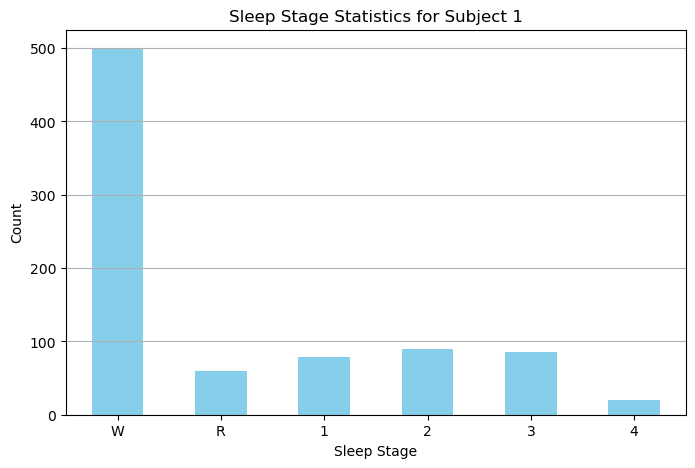

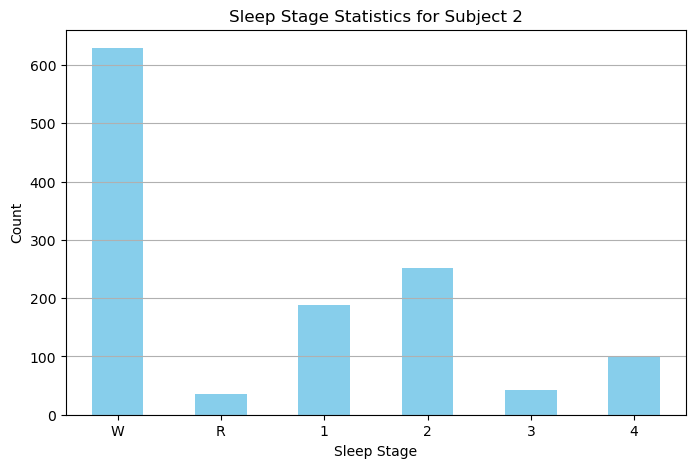

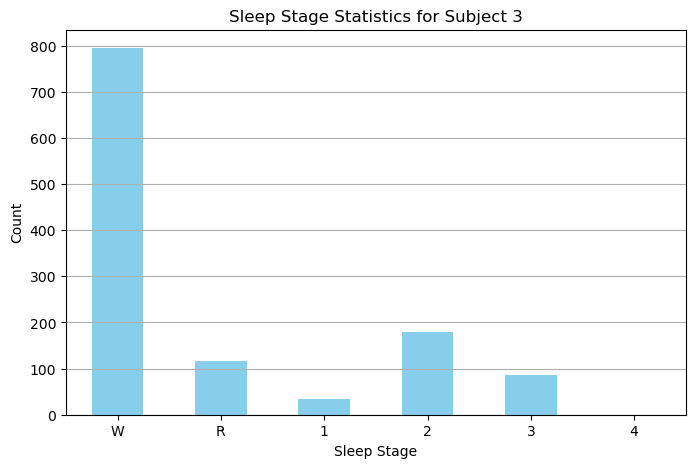

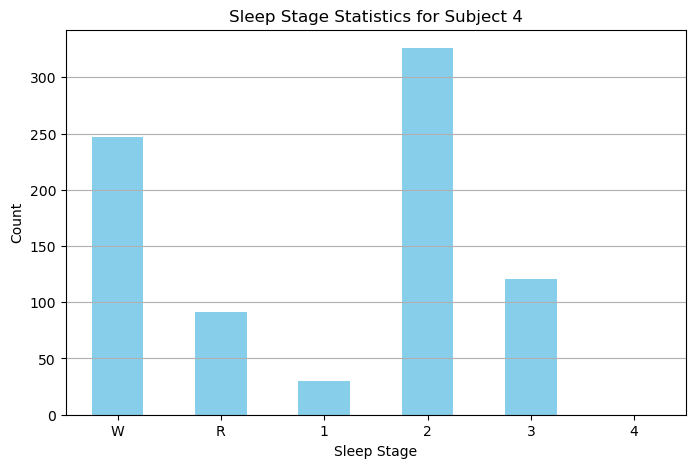

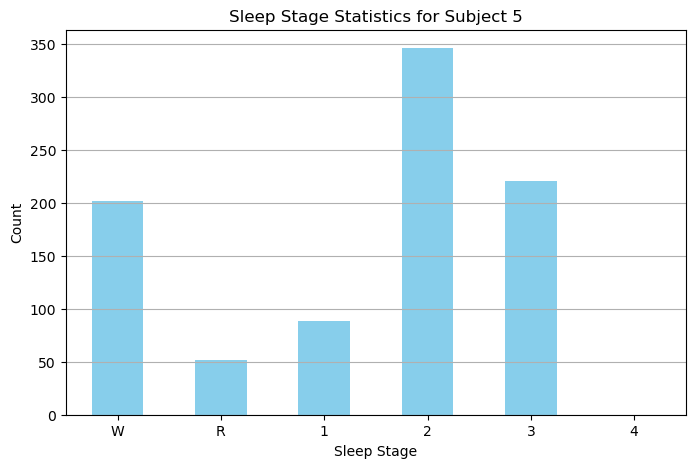

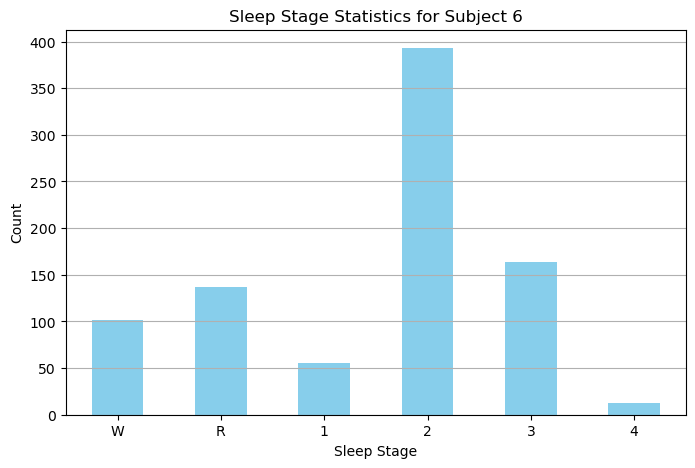

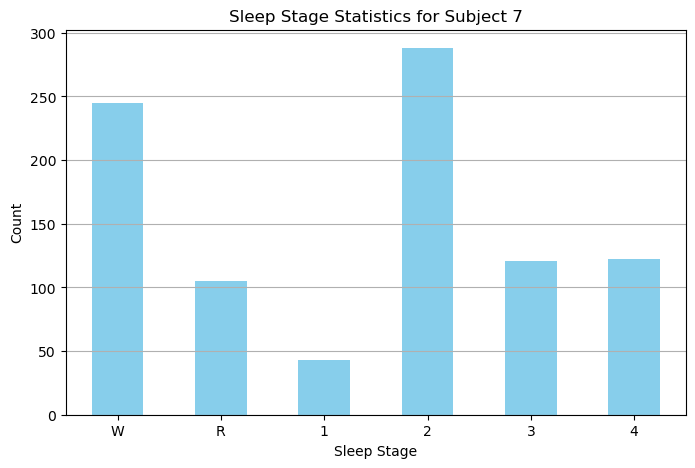

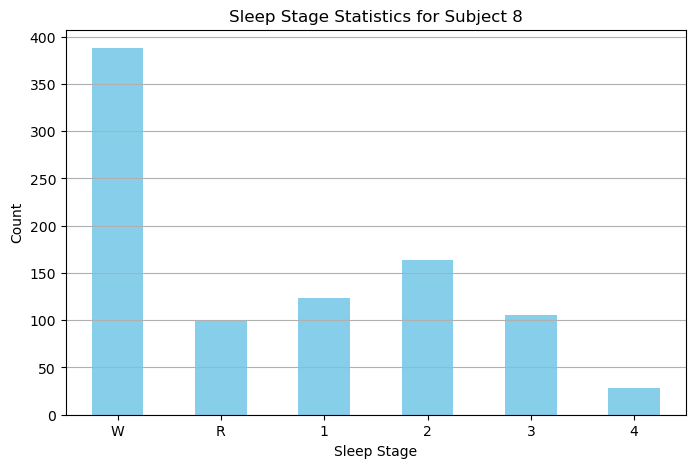

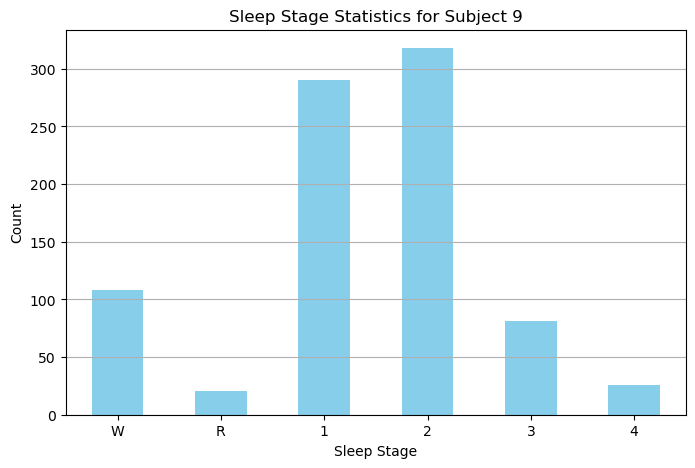

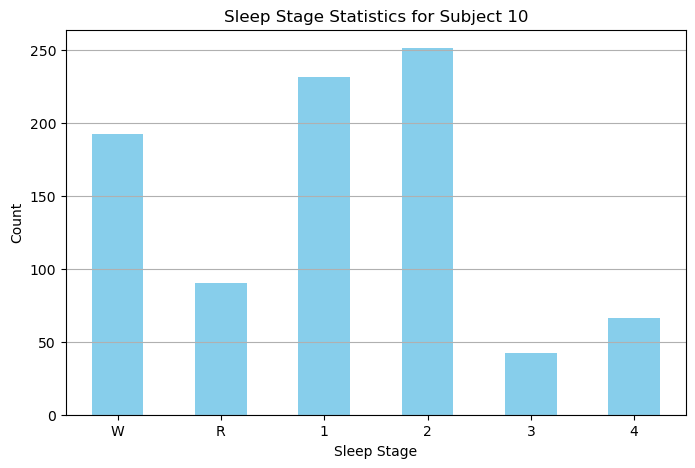

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sampling rate
sampling_rate = 128  # Hz
epoch_duration = 30  # seconds
batch_size = sampling_rate * epoch_duration  # Number of samples per batch

# Function to load hypnogram (sleep stage labels) and PPG data
def load_data(hypno_file, pleth_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    pleth_data = np.loadtxt(pleth_file, skiprows=1)  # Skip the header line
    return hypno_data, pleth_data

# Function to segment PPG data into batches for 30-second epochs
def segment_batches(ppg_data):
    num_batches = len(ppg_data) // batch_size
    return np.array_split(ppg_data, num_batches)

# Function to generate statistics of sleep stages for each subject
def calculate_sleep_stage_stats(hypno_data):
    sleep_stage_stats = hypno_data['Label'].value_counts().reindex(['W', 'R', '1', '2', '3', '4']).fillna(0)
    return sleep_stage_stats

# File names
file_names = ['AHI11.2-1Hypno.txt', 'AHI11.2-1Pleth.txt',
              'AHI16.2-1Hypno.txt', 'AHI16.2-1Pleth.txt',
              'AHI17.3-1Hypno.txt', 'AHI17.3-1Pleth.txt', 
              'AHI18.4-1Hypno.txt', 'AHI18.4-1Pleth.txt',
              'AHI19.2-1Hypno.txt', 'AHI19.2-1Pleth.txt',
              'AHI20.8-1Hypno.txt', 'AHI20.8-1Pleth.txt',
              'AHI22.1-1Hypno.txt', 'AHI22.1-1Pleth.txt',
              'AHI28.3-1Hypno.txt', 'AHI28.3-1Pleth.txt',
              'AHI52.5-1Hypno.txt', 'AHI52.5-1Pleth.txt',
              'AHI68.7-1Hypno.txt', 'AHI68.7-1Pleth.txt']

# Process each subject's data
for i in range(0, len(file_names), 2):
    hypno_file = file_names[i]
    pleth_file = file_names[i + 1]
    subject_id = i // 2 + 1
    
    # Load data
    hypno_data, _ = load_data(hypno_file, pleth_file)
    
    # Calculate sleep stage statistics
    sleep_stage_stats = calculate_sleep_stage_stats(hypno_data)
    
    # Plot sleep stage statistics
    plt.figure(figsize=(8, 5))
    sleep_stage_stats.plot(kind='bar', color='skyblue')
    plt.title(f'Sleep Stage Statistics for Subject {subject_id}')
    plt.xlabel('Sleep Stage')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()


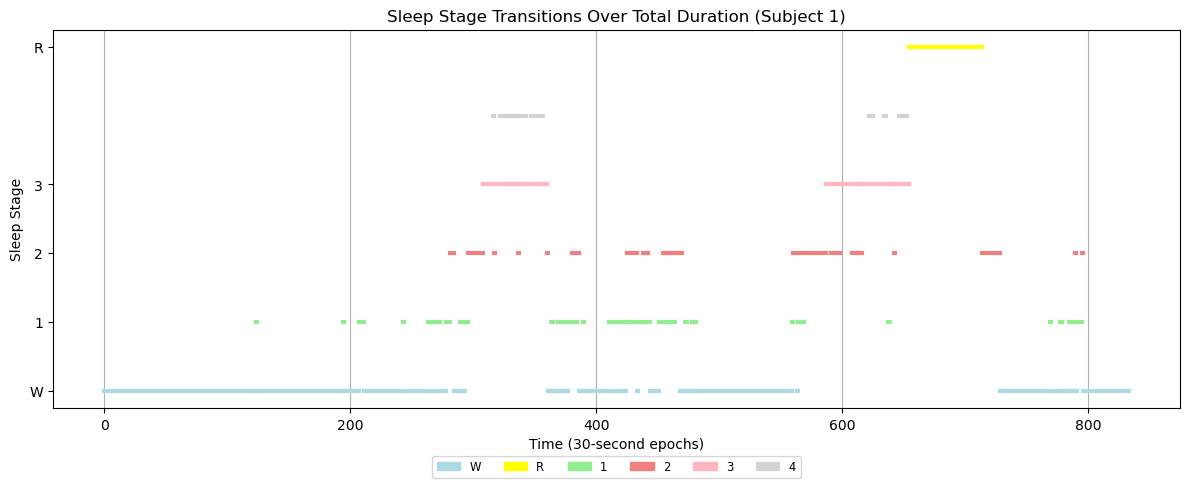

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Function to load hypnogram (sleep stage labels)
def load_hypnogram(hypno_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    return hypno_data

# File names
hypno_file = 'AHI11.2-1Hypno.txt'

# Load hypnogram data for Subject 1
hypno_data = load_hypnogram(hypno_file)

# Define colors for different sleep stages
color_map = {
    'W': 'lightblue',
    'R': 'yellow',
    '1': 'lightgreen',
    '2': 'lightcoral',
    '3': 'lightpink',
    '4': 'lightgrey'
}

# Function to plot sleep stages transitions over total duration
def plot_sleep_stage_transitions(hypno_data):
    plt.figure(figsize=(12, 5))
    
    # Initialize variables
    prev_stage = hypno_data.iloc[0]['Label']
    start_epoch = 0
    
    # Plot sleep stages transitions
    for i, row in hypno_data.iterrows():
        current_stage = row['Label']
        if current_stage != prev_stage:
            plt.plot([start_epoch, i], [prev_stage] * 2, color=color_map[prev_stage], linewidth=3)
            start_epoch = i
            prev_stage = current_stage
    
    # Plot the last segment
    plt.plot([start_epoch, len(hypno_data)], [prev_stage] * 2, color=color_map[prev_stage], linewidth=3, label='Sleep Stage Transitions')
    
    # Create custom legend
    legend_patches = [Patch(color=color, label=label) for label, color in color_map.items()]
    plt.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(color_map), fontsize='small')
    
    plt.yticks(['W', 'R', '1', '2', '3'])
    plt.xlabel('Time (30-second epochs)')
    plt.ylabel('Sleep Stage')
    plt.title('Sleep Stage Transitions Over Total Duration (Subject 1)')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

# Plot sleep stage transitions for Subject 1
plot_sleep_stage_transitions(hypno_data)


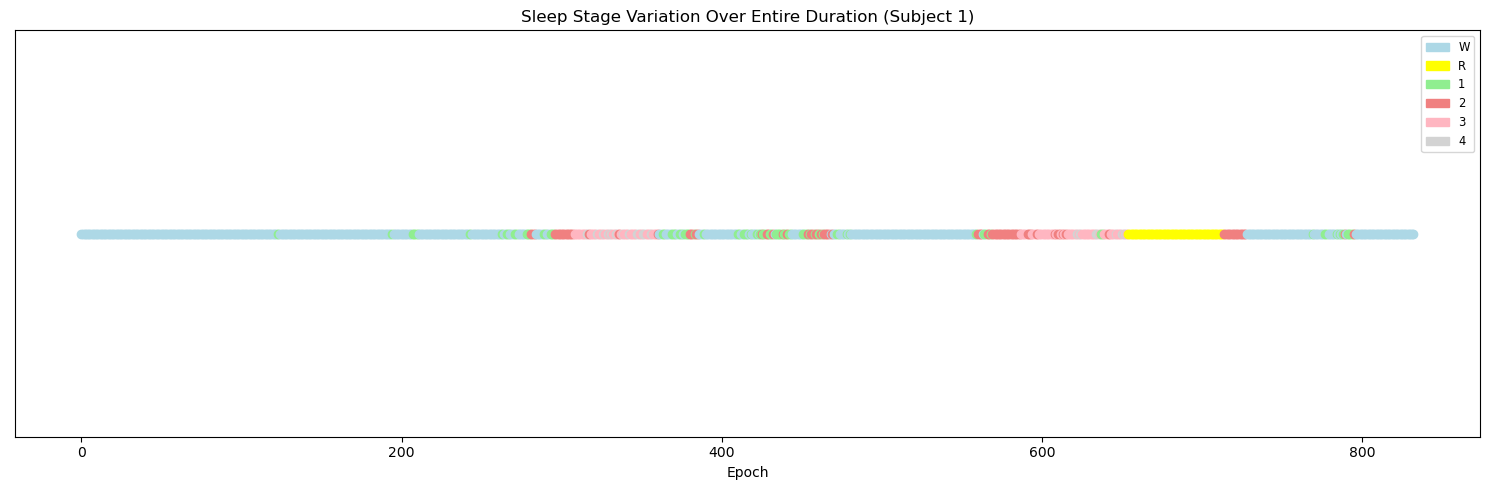

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Function to load hypnogram (sleep stage labels)
def load_hypnogram(hypno_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    return hypno_data

# File names
hypno_file = 'AHI11.2-1Hypno.txt'

# Load hypnogram data for Subject 1
hypno_data = load_hypnogram(hypno_file)

# Define colors for different sleep stages
color_map = {
    'W': 'lightblue',
    'R': 'yellow',
    '1': 'lightgreen',
    '2': 'lightcoral',
    '3': 'lightpink',
    '4': 'lightgrey'
}

# Function to plot sleep stages over the entire duration
def plot_sleep_stages(hypno_data):
    plt.figure(figsize=(15, 5))

    # Plot each sleep stage as scatter points
    for i, row in hypno_data.iterrows():
        plt.scatter(i, 0, color=color_map[row['Label']], marker='o')

    # Create custom legend
    legend_patches = [Patch(color=color, label=label) for label, color in color_map.items()]
    plt.legend(handles=legend_patches, loc='upper right', fontsize='small')

    # Set y-axis limits and remove y-axis ticks
    plt.ylim(-0.5, 0.5)
    plt.yticks([])

    # Set x-axis label and title
    plt.xlabel('Epoch')
    plt.title('Sleep Stage Variation Over Entire Duration (Subject 1)')

    plt.tight_layout()
    plt.show()

# Plot sleep stages for Subject 1
plot_sleep_stages(hypno_data)


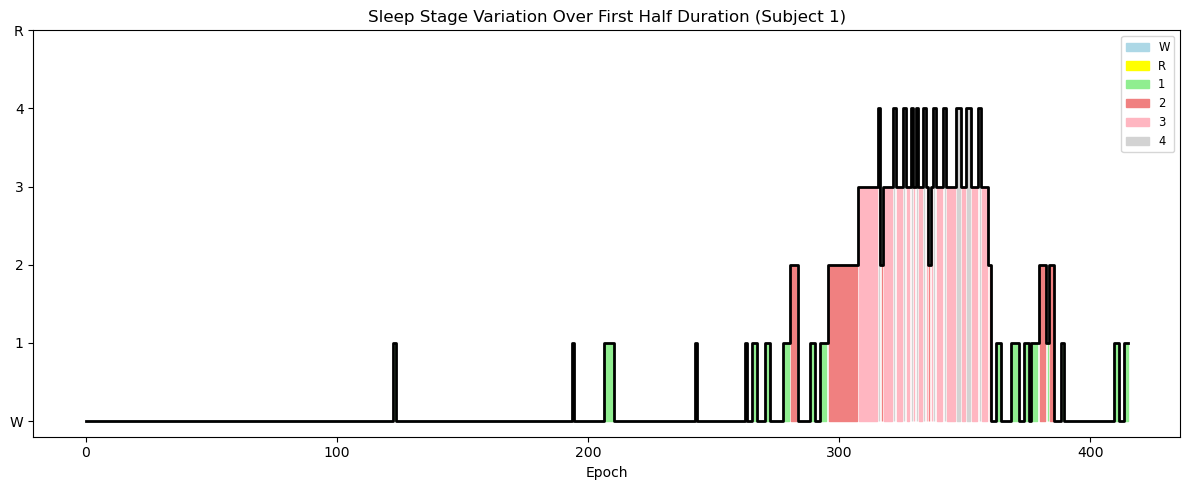

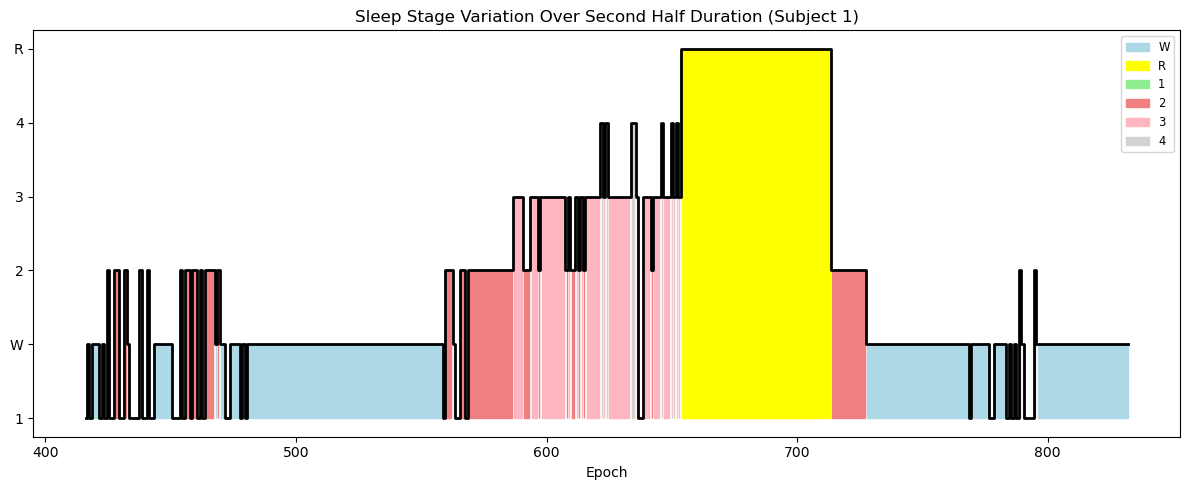

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to load hypnogram (sleep stage labels)
def load_hypnogram(hypno_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    return hypno_data

# File names
hypno_file = 'AHI11.2-1Hypno.txt'

# Load hypnogram data for Subject 1
hypno_data = load_hypnogram(hypno_file)

# Define colors for different sleep stages
color_map = {
    'W': 'lightblue',
    'R': 'yellow',
    '1': 'lightgreen',
    '2': 'lightcoral',
    '3': 'lightpink',
    '4': 'lightgrey'
}

# Function to plot sleep stages for the first half of the duration
def plot_first_half(hypno_data):
    plt.figure(figsize=(12, 5))
    
    # Plot step plot for sleep stages for the first half
    plt.step(range(len(hypno_data)//2), hypno_data['Label'].iloc[:len(hypno_data)//2], color='black', where='mid', linewidth=2)
    
    # Add color patches for sleep stages for the first half
    for label, color in color_map.items():
        plt.fill_between(range(len(hypno_data)//2), label, where=hypno_data['Label'].iloc[:len(hypno_data)//2] == label, color=color)
    
    # Create custom legend
    legend_handles = [plt.Rectangle((0,0),1,1, color=color) for label, color in color_map.items()]
    plt.legend(legend_handles, color_map.keys(), loc='upper right', fontsize='small')
    
    # Set y-axis ticks and labels
    plt.yticks(list(color_map.keys()), list(color_map.keys()))
    
    # Set x-axis label and title
    plt.xlabel('Epoch')
    plt.title('Sleep Stage Variation Over First Half Duration (Subject 1)')
    
    plt.tight_layout()
    plt.show()

# Function to plot sleep stages for the second half of the duration
def plot_second_half(hypno_data):
    plt.figure(figsize=(12, 5))
    
    # Plot step plot for sleep stages for the second half
    plt.step(range(len(hypno_data)//2, len(hypno_data)), hypno_data['Label'].iloc[len(hypno_data)//2:], color='black', where='mid', linewidth=2)
    
    # Add color patches for sleep stages for the second half
    for label, color in color_map.items():
        plt.fill_between(range(len(hypno_data)//2, len(hypno_data)), label, where=hypno_data['Label'].iloc[len(hypno_data)//2:] == label, color=color)
    
    # Create custom legend
    legend_handles = [plt.Rectangle((0,0),1,1, color=color) for label, color in color_map.items()]
    plt.legend(legend_handles, color_map.keys(), loc='upper right', fontsize='small')
    
    # Set y-axis ticks and labels
    plt.yticks(list(color_map.keys()), list(color_map.keys()))
    
    # Set x-axis label and title
    plt.xlabel('Epoch')
    plt.title('Sleep Stage Variation Over Second Half Duration (Subject 1)')
    
    plt.tight_layout()
    plt.show()

# Plot sleep stages for the first half
plot_first_half(hypno_data)

# Plot sleep stages for the second half
plot_second_half(hypno_data)


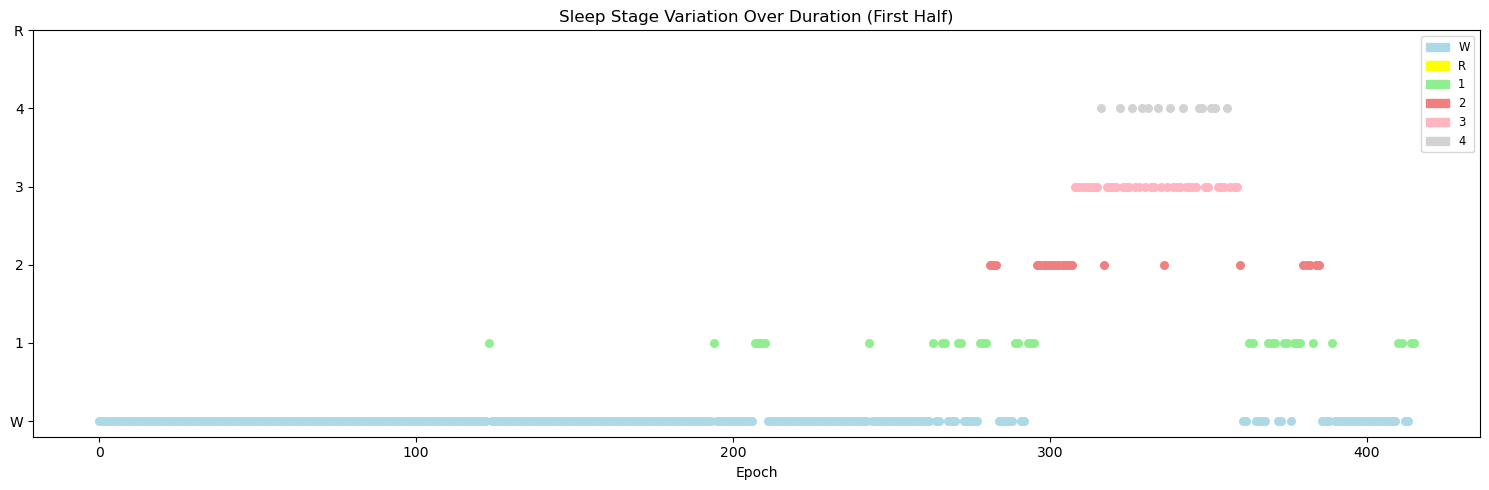

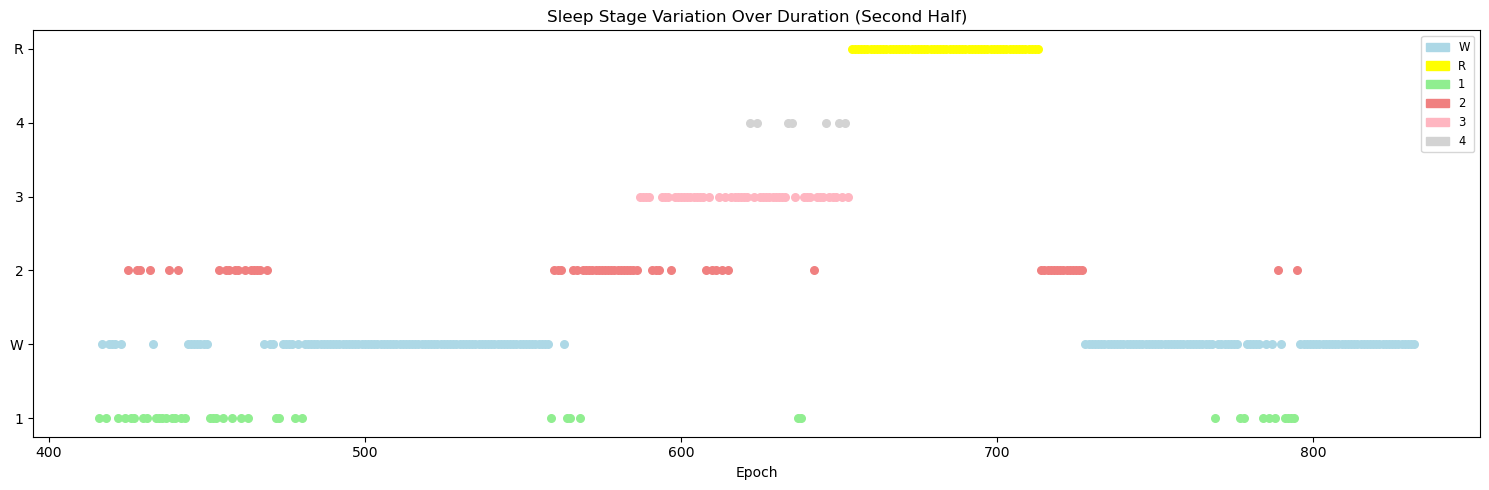

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to load hypnogram (sleep stage labels)
def load_hypnogram(hypno_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    return hypno_data

# File names
hypno_file = 'AHI11.2-1Hypno.txt'

# Load hypnogram data for Subject 1
hypno_data = load_hypnogram(hypno_file)

# Define colors for different sleep stages
color_map = {
    'W': 'lightblue',
    'R': 'yellow',
    '1': 'lightgreen',
    '2': 'lightcoral',
    '3': 'lightpink',
    '4': 'lightgrey'
}

# Function to plot sleep stages using scatter points
def plot_sleep_stages_scatter(hypno_data, title_suffix):
    plt.figure(figsize=(15, 5))

    # Plot scatter points for sleep stages
    for i, row in hypno_data.iterrows():
        plt.scatter(i, row['Label'], color=color_map[row['Label']], marker='o', s=30)

    # Create custom legend
    legend_handles = [plt.Rectangle((0,0),1,1, color=color) for label, color in color_map.items()]
    plt.legend(legend_handles, color_map.keys(), loc='upper right', fontsize='small')

    # Set y-axis ticks and labels
    plt.yticks(list(color_map.keys()), list(color_map.keys()))

    # Set x-axis label and title
    plt.xlabel('Epoch')
    plt.title(f'Sleep Stage Variation Over Duration ({title_suffix})')

    plt.tight_layout()
    plt.show()

# Split hypnogram data into first and second halves
half_length = len(hypno_data) // 2
first_half_data = hypno_data.iloc[:half_length]
second_half_data = hypno_data.iloc[half_length:]

# Plot sleep stages for the first half using scatter points
plot_sleep_stages_scatter(first_half_data, 'First Half')

# Plot sleep stages for the second half using scatter points
plot_sleep_stages_scatter(second_half_data, 'Second Half')


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to load hypnogram (sleep stage labels)
def load_hypnogram(hypno_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    return hypno_data

# File names
hypno_file = 'AHI11.2-1Hypno.txt'

# Load hypnogram data for Subject 1
hypno_data = load_hypnogram(hypno_file)

# Define colors for different sleep stages
color_map = {
    'W': 'lightblue',
    'R': 'yellow',
    '1': 'lightgreen',
    '2': 'lightcoral',
    '3': 'lightpink',
    '4': 'lightgrey'
}

# Function to plot sleep stage transitions using a line chart
def plot_sleep_stage_transitions_line(hypno_data, title_suffix):
    plt.figure(figsize=(15, 5))

    # Initialize variables
    prev_stage = hypno_data.iloc[0]['Label']
    start_epoch = 0

    # Plot each sleep stage transition
    for i, row in hypno_data.iterrows():
        current_stage = row['Label']
        if current_stage != prev_stage:
            plt.plot([start_epoch, i], [prev_stage, current_stage], color=color_map[prev_stage], linewidth=2)
            start_epoch = i
            prev_stage = current_stage
    
    # Plot the last segment
    plt.plot([start_epoch, len(hypno_data)], [prev_stage] * 2, color=color_map[prev_stage], linewidth=2)

    # Create custom legend
    legend_handles = [plt.Line2D([0], [0], color=color, linewidth=2, label=label) for label, color in color_map.items()]
    plt.legend(handles=legend_handles, loc='upper right', fontsize='small')

    # Set y-axis ticks and labels
    plt.yticks(list(color_map.keys()), list(color_map.keys()))

    # Set x-axis label and title
    plt.xlabel('Epoch')
    plt.title(f'Sleep Stage Variation Over Duration ({title_suffix})')

    plt.tight_layout()
    plt.show()

# Split hypnogram data into first half
half_length = len(hypno_data) // 2
first_half_data = hypno_data.iloc[:half_length]

# Plot sleep stage transitions for the first half using line chart
plot_sleep_stage_transitions_line(first_half_data, 'First Half')


FileNotFoundError: [Errno 2] No such file or directory: 'AHI11.2-1Hypno.txt'

In [16]:
import os
import numpy as np
import pandas as pd

# Sampling rate
sampling_rate = 128  # Hz
epoch_duration = 30  # seconds
batch_size = sampling_rate * epoch_duration  # Number of samples per batch

# Function to load hypnogram (sleep stage labels) and PPG data
def load_data(hypno_file, pleth_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    pleth_data = np.loadtxt(pleth_file, skiprows=1)  # Skip the header line
    return hypno_data, pleth_data

# Function to segment PPG data into batches for 30-second epochs
def segment_batches(ppg_data):
    num_batches = len(ppg_data) // batch_size
    return np.array_split(ppg_data, num_batches)

# Function to generate a table summarizing segmented PPG data and corresponding labels
def summarize_data(ppg_batches, hypno_data):
    summary_data = pd.DataFrame(columns=['Batch', 'PPG Signal', 'Sleep Stage'])
    for i, batch in enumerate(ppg_batches):
        sleep_stage_label = hypno_data.iloc[i]["Label"]
        summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
    return summary_data

# Subfolder name
subfolder = "data"

# File names
file_names = ['AHI11.2-1Hypno.txt', 'AHI11.2-1Pleth.txt',
              'AHI16.2-1Hypno.txt', 'AHI16.2-1Pleth.txt',
              'AHI17.3-1Hypno.txt', 'AHI17.3-1Pleth.txt', 
              'AHI18.4-1Hypno.txt', 'AHI18.4-1Pleth.txt',
              'AHI19.2-1Hypno.txt', 'AHI19.2-1Pleth.txt',
              'AHI20.8-1Hypno.txt', 'AHI20.8-1Pleth.txt',
              'AHI22.1-1Hypno.txt', 'AHI22.1-1Pleth.txt',
              'AHI28.3-1Hypno.txt', 'AHI28.3-1Pleth.txt',
              'AHI52.5-1Hypno.txt', 'AHI52.5-1Pleth.txt',
              'AHI68.7-1Hypno.txt', 'AHI68.7-1Pleth.txt']

# Process each subject's data
for i in range(0, len(file_names), 2):
    hypno_file = os.path.join(subfolder, file_names[i])
    pleth_file = os.path.join(subfolder, file_names[i + 1])
    subject_id = i // 2 + 1
    
    # Load data
    try:
        hypno_data, pleth_data = load_data(hypno_file, pleth_file)
    except Exception as e:
        print(f"Error loading {hypno_file} and {pleth_file}: {e}")
        continue
    
    # Segment PPG data into batches
    ppg_batches = segment_batches(pleth_data)
    
    # Generate summary table
    summary_table = summarize_data(ppg_batches, hypno_data)
    print(f"Summary Table for Subject {subject_id}:")
    print(summary_table)



C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True

Summary Table for Subject 1:
    Batch                                         PPG Signal Sleep Stage
0       1  [-0.257247, -0.275608, -0.295911, -0.320192, -...           W
1       2  [-0.591735, -0.572925, -0.556318, -0.542782, -...           W
2       3  [-0.582243, -0.572943, -0.564421, -0.555654, -...           W
3       4  [-0.766487, -0.765949, -0.763442, -0.758951, -...           W
4       5  [-0.208953, -0.20019, -0.193694, -0.185476, -0...           W
..    ...                                                ...         ...
828   829  [-0.776345, -0.772142, -0.766511, -0.758237, -...           W
829   830  [-0.71239, -0.707081, -0.703238, -0.696866, -0...           W
830   831  [-0.70098, -0.702305, -0.704249, -0.702292, -0...           W
831   832  [-0.508909, -0.508525, -0.506217, -0.504441, -...           W
832   833  [-0.343486, -0.356318, -0.372085, -0.390512, -...           W

[833 rows x 3 columns]


C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True

Summary Table for Subject 2:
     Batch                                         PPG Signal Sleep Stage
0        1  [-0.0136753, -0.0136088, -0.0135901, -0.012944...           W
1        2  [-0.989824, -0.989745, -0.988815, -0.988779, -...           W
2        3  [-0.9895, -0.989871, -0.989239, -0.988832, -0....           W
3        4  [-0.989344, -0.989362, -0.989476, -0.988272, -...           W
4        5  [-0.989111, -0.98894, -0.989789, -0.990198, -0...           W
...    ...                                                ...         ...
1241  1242  [-0.497199, -0.494079, -0.489664, -0.48549, -0...           W
1242  1243  [-0.605523, -0.601395, -0.597632, -0.593082, -...           W
1243  1244  [-0.430529, -0.42398, -0.421443, -0.415917, -0...           W
1244  1245  [-0.525709, -0.520297, -0.515541, -0.510397, -...           W
1245  1246  [-0.500786, -0.496042, -0.49464, -0.489527, -0...           W

[1246 rows x 3 columns]


C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True

Summary Table for Subject 3:
     Batch                                         PPG Signal Sleep Stage
0        1  [-0.678415, -0.67264, -0.66811, -0.664432, -0....           W
1        2  [-0.708997, -0.701587, -0.695765, -0.691099, -...           W
2        3  [-0.53163, -0.528075, -0.523914, -0.520403, -0...           W
3        4  [-0.608819, -0.602196, -0.595192, -0.589184, -...           W
4        5  [-0.591883, -0.587723, -0.584595, -0.581628, -...           W
...    ...                                                ...         ...
1207  1208  [-0.373304, -0.364163, -0.357514, -0.35029, -0...           W
1208  1209  [-0.399976, -0.393377, -0.387357, -0.379894, -...           W
1209  1210  [-0.298541, -0.292569, -0.28709, -0.279543, -0...           W
1210  1211  [-0.274327, -0.269098, -0.262433, -0.257225, -...           W
1211  1212  [-0.300698, -0.29381, -0.287641, -0.280872, -0...           W

[1212 rows x 3 columns]


C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True

Summary Table for Subject 4:
    Batch                                         PPG Signal Sleep Stage
0       1  [-0.679278, -0.672312, -0.663282, -0.654915, -...           W
1       2  [-0.441926, -0.435965, -0.430101, -0.422821, -...           W
2       3  [-0.570592, -0.565902, -0.56069, -0.555219, -0...           W
3       4  [-0.290945, -0.285098, -0.276797, -0.268349, -...           W
4       5  [-0.446473, -0.43769, -0.428088, -0.419555, -0...           W
..    ...                                                ...         ...
810   811  [-0.731754, -0.736116, -0.738971, -0.741629, -...           2
811   812  [-0.423057, -0.414473, -0.405157, -0.396109, -...           2
812   813  [-0.522354, -0.516124, -0.510171, -0.502838, -...           2
813   814  [-0.287657, -0.279965, -0.27323, -0.264493, -0...           2
814   815  [-0.702493, -0.723175, -0.743173, -0.763366, -...           2

[815 rows x 3 columns]


C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True

Summary Table for Subject 5:
    Batch                                         PPG Signal Sleep Stage
0       1  [-0.493487, -0.483997, -0.478667, -0.470089, -...           W
1       2  [-0.340296, -0.330283, -0.321086, -0.311839, -...           W
2       3  [-0.141152, -0.141361, -0.145251, -0.155515, -...           W
3       4  [-0.536437, -0.530335, -0.522231, -0.517546, -...           W
4       5  [-0.676424, -0.666807, -0.657076, -0.647484, -...           W
..    ...                                                ...         ...
904   905  [-0.59336, -0.589753, -0.586933, -0.584314, -0...           3
905   906  [-0.525882, -0.534988, -0.540998, -0.54892, -0...           3
906   907  [-0.413193, -0.432683, -0.449749, -0.466618, -...           3
907   908  [-0.381807, -0.374921, -0.367005, -0.360816, -...           3
908   909  [-0.545202, -0.554286, -0.562024, -0.568444, -...           3

[909 rows x 3 columns]


C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True

Summary Table for Subject 6:
    Batch                                         PPG Signal Sleep Stage
0       1  [-0.487085, -0.479863, -0.472527, -0.464292, -...           W
1       2  [-0.399034, -0.391947, -0.385295, -0.378273, -...           W
2       3  [-0.607562, -0.584131, -0.562758, -0.548507, -...           W
3       4  [-0.684092, -0.679436, -0.674904, -0.670829, -...           W
4       5  [-0.656834, -0.651153, -0.647184, -0.641635, -...           W
..    ...                                                ...         ...
859   860  [-0.552681, -0.574593, -0.597077, -0.61618, -0...           R
860   861  [-0.38078, -0.375241, -0.367662, -0.361492, -0...           R
861   862  [-0.783405, -0.777841, -0.771788, -0.764485, -...           R
862   863  [-0.62497, -0.638138, -0.652572, -0.664608, -0...           R
863   864  [-0.17411, -0.168262, -0.162373, -0.158924, -0...           R

[864 rows x 3 columns]


C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True

Summary Table for Subject 7:
    Batch                                         PPG Signal Sleep Stage
0       1  [-0.509532, -0.536869, -0.563364, -0.589237, -...           W
1       2  [-0.398284, -0.385674, -0.373296, -0.363, -0.3...           W
2       3  [-0.892731, -0.889639, -0.882123, -0.875537, -...           W
3       4  [-0.545453, -0.531941, -0.518317, -0.503787, -...           W
4       5  [-0.859072, -0.847155, -0.833667, -0.821378, -...           W
..    ...                                                ...         ...
919   920  [-0.641659, -0.640331, -0.639023, -0.636339, -...           R
920   921  [-0.518309, -0.508667, -0.50075, -0.490881, -0...           W
921   922  [-0.769642, -0.779776, -0.789211, -0.798108, -...           W
922   923  [-0.671214, -0.686723, -0.700501, -0.710832, -...           2
923   924  [-0.494062, -0.494878, -0.492718, -0.492983, -...           2

[924 rows x 3 columns]


C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True

Summary Table for Subject 8:
    Batch                                         PPG Signal Sleep Stage
0       1  [-0.52072, -0.514224, -0.509157, -0.501794, -0...           W
1       2  [-0.732054, -0.747174, -0.761817, -0.771909, -...           W
2       3  [-0.723528, -0.718376, -0.711952, -0.70591, -0...           W
3       4  [-0.266719, -0.281, -0.30119, -0.320996, -0.34...           W
4       5  [-0.331832, -0.317106, -0.305674, -0.292135, -...           W
..    ...                                                ...         ...
904   905  [-0.390459, -0.416651, -0.44241, -0.468249, -0...           R
905   906  [-0.649321, -0.638264, -0.627273, -0.615825, -...           R
906   907  [-0.685152, -0.675633, -0.666453, -0.65661, -0...           R
907   908  [-0.235273, -0.254175, -0.275143, -0.296704, -...           R
908   909  [-0.619766, -0.614688, -0.610234, -0.603943, -...           R

[909 rows x 3 columns]


C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True

Summary Table for Subject 9:
    Batch                                         PPG Signal Sleep Stage
0       1  [-0.654837, -0.649102, -0.641034, -0.633247, -...           W
1       2  [-0.357015, -0.360393, -0.364637, -0.370152, -...           W
2       3  [-0.271188, -0.266882, -0.260285, -0.252575, -...           W
3       4  [-0.404689, -0.403865, -0.403604, -0.403192, -...           W
4       5  [-0.686075, -0.681688, -0.679193, -0.675784, -...           W
..    ...                                                ...         ...
839   840  [-0.173519, -0.165794, -0.158999, -0.155356, -...           W
840   841  [-0.3742, -0.368525, -0.364313, -0.359622, -0....           W
841   842  [-0.541139, -0.534104, -0.527675, -0.521798, -...           W
842   843  [-0.501413, -0.49604, -0.495646, -0.49295, -0....           W
843   844  [-0.206472, -0.22783, -0.247332, -0.272326, -0...           W

[844 rows x 3 columns]


C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True)
C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_28436\674513604.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_data = summary_data.append({'Batch': i + 1, 'PPG Signal': batch, 'Sleep Stage': sleep_stage_label}, ignore_index=True

Summary Table for Subject 10:
    Batch                                         PPG Signal Sleep Stage
0       1  [-0.074769, -0.0823272, -0.0940605, -0.109044,...           W
1       2  [-0.367701, -0.360769, -0.353699, -0.34732, -0...           W
2       3  [-0.644682, -0.630845, -0.614232, -0.597509, -...           W
3       4  [-0.19278, -0.180795, -0.16692, -0.155246, -0....           W
4       5  [-0.573076, -0.560229, -0.547502, -0.53298, -0...           W
..    ...                                                ...         ...
867   868  [-0.304105, -0.298418, -0.293208, -0.28692, -0...           2
868   869  [-0.545759, -0.543339, -0.5393, -0.536167, -0....           1
869   870  [-0.402211, -0.39391, -0.388307, -0.381497, -0...           1
870   871  [-0.294442, -0.289465, -0.285084, -0.279908, -...           1
871   872  [-0.707248, -0.698813, -0.69071, -0.682906, -0...           W

[872 rows x 3 columns]


In [23]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Sampling rate
sampling_rate = 128  # Hz
epoch_duration = 30  # seconds
batch_size = sampling_rate * epoch_duration  # Number of samples per batch

# Function to load hypnogram (sleep stage labels) and PPG data
def load_data(hypno_file, pleth_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    pleth_data = np.loadtxt(pleth_file, skiprows=1)  # Skip the header line
    return hypno_data, pleth_data

# Function to segment PPG data into batches for 30-second epochs
def segment_batches(ppg_data):
    num_batches = len(ppg_data) // batch_size
    return np.array_split(ppg_data, num_batches)

# Function to preprocess data
def preprocess_data(ppg_batches, hypno_data):
    labels_encoded = []
    ppg_data_normalized = []

    label_encoder = LabelEncoder()
    for i, batch in enumerate(ppg_batches):
        sleep_stage_label = hypno_data.iloc[i]["Label"]
        if sleep_stage_label in ['1', '2', '3', '4']:
            sleep_stage_label = 'N'
        labels_encoded.append(label_encoder.fit_transform([sleep_stage_label])[0])
        ppg_data_normalized.append(batch)

    scaler = StandardScaler()
    ppg_data_normalized = scaler.fit_transform(np.array(ppg_data_normalized))

    return np.array(ppg_data_normalized), np.array(labels_encoded)

# Define CNN architecture
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Subfolder name
subfolder = "data"

# File names
file_names = ['AHI11.2-1Hypno.txt', 'AHI11.2-1Pleth.txt',
              'AHI16.2-1Hypno.txt', 'AHI16.2-1Pleth.txt',
              'AHI17.3-1Hypno.txt', 'AHI17.3-1Pleth.txt', 
              'AHI18.4-1Hypno.txt', 'AHI18.4-1Pleth.txt',
              'AHI19.2-1Hypno.txt', 'AHI19.2-1Pleth.txt',
              'AHI20.8-1Hypno.txt', 'AHI20.8-1Pleth.txt',
              'AHI22.1-1Hypno.txt', 'AHI22.1-1Pleth.txt',
              'AHI28.3-1Hypno.txt', 'AHI28.3-1Pleth.txt',
              'AHI52.5-1Hypno.txt', 'AHI52.5-1Pleth.txt',
              'AHI68.7-1Hypno.txt', 'AHI68.7-1Pleth.txt']

# Process each subject's data
for i in range(0, len(file_names), 2):
    hypno_file = os.path.join(subfolder, file_names[i])
    pleth_file = os.path.join(subfolder, file_names[i + 1])
    subject_id = i // 2 + 1
    
    # Load data
    try:
        hypno_data, pleth_data = load_data(hypno_file, pleth_file)
    except Exception as e:
        print(f"Error loading {hypno_file} and {pleth_file}: {e}")
        continue
    
    # Segment PPG data into batches
    ppg_batches = segment_batches(pleth_data)
    
    # Preprocess data
    X, y = preprocess_data(ppg_batches, hypno_data)
    
    # Data splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Display shapes of train and test sets
    print(f"Shape of X_train for Subject {subject_id}:", X_train.shape)
    print(f"Shape of y_train for Subject {subject_id}:", y_train.shape)
    print(f"Shape of X_test for Subject {subject_id}:", X_test.shape)
    print(f"Shape of y_test for Subject {subject_id}:", y_test.shape)
    
    # Define input shape and number of classes
    input_shape = X_train.shape[1:]
    num_classes = len(np.unique(y))
    
    # Create and compile the model
    model = create_model(input_shape, num_classes)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss for Subject {subject_id}: {loss}, Test Accuracy: {accuracy}')


Shape of X_train for Subject 1: (666, 3840)
Shape of y_train for Subject 1: (666,)
Shape of X_test for Subject 1: (167, 3840)
Shape of y_test for Subject 1: (167,)


ValueError: Input 0 of layer "conv1d_4" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 3840)

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import os

# Sampling rate
sampling_rate = 128  # Hz
epoch_duration = 30  # seconds
batch_size = sampling_rate * epoch_duration  # Number of samples per batch

# Function to load hypnogram (sleep stage labels) and PPG data
def load_data(hypno_file, pleth_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    pleth_data = np.loadtxt(pleth_file, skiprows=1)  # Skip the header line
    return hypno_data, pleth_data

# Function to segment PPG data into batches for 30-second epochs
def segment_batches(ppg_data):
    num_batches = len(ppg_data) // batch_size
    return np.array_split(ppg_data, num_batches)

# File names
file_names = ['AHI11.2-1Hypno.txt', 'AHI11.2-1Pleth.txt',
              'AHI16.2-1Hypno.txt', 'AHI16.2-1Pleth.txt',
              'AHI17.3-1Hypno.txt', 'AHI17.3-1Pleth.txt', 
              'AHI18.4-1Hypno.txt', 'AHI18.4-1Pleth.txt',
              'AHI19.2-1Hypno.txt', 'AHI19.2-1Pleth.txt',
              'AHI20.8-1Hypno.txt', 'AHI20.8-1Pleth.txt',
              'AHI22.1-1Hypno.txt', 'AHI22.1-1Pleth.txt',
              'AHI28.3-1Hypno.txt', 'AHI28.3-1Pleth.txt',
              'AHI52.5-1Hypno.txt', 'AHI52.5-1Pleth.txt',
              'AHI68.7-1Hypno.txt', 'AHI68.7-1Pleth.txt']

# Process each subject's data
for i in range(0, len(file_names), 2):
    hypno_file = os.path.join('data', file_names[i])
    pleth_file = os.path.join('data', file_names[i + 1])
    subject_id = i // 2 + 1
    
    # Check if files exist
    if not os.path.exists(hypno_file) or not os.path.exists(pleth_file):
        print(f"Files not found for subject {subject_id}")
        continue
    
    # Load data
    hypno_data, pleth_data = load_data(hypno_file, pleth_file)
    
    # Segment PPG data into batches
    ppg_batches = segment_batches(pleth_data)
    
    # Label Encoding
    original_labels = ['W', 'R', '1', '2', '3', '4']

    # Merge '1', '2', '3', and '4' into 'N'
    preprocessed_labels = ['N' if label in ['1', '2', '3', '4'] else label for label in original_labels]

    # Use LabelEncoder to encode the preprocessed labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(preprocessed_labels)
    # labels = hypno_data['Label'].values
    # label_encoder = LabelEncoder()
    # y = label_encoder.fit_transform(labels)
    
    # Preprocessing
    X = np.array(ppg_batches)
    y = np.array(y)
    
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Further preprocessing
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    # Define CNN architecture
    model = Sequential([
        Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train_normalized.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Output layer with 3 neurons for W, R, N
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train_normalized, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_normalized, y_test)
    print(f'Subject {subject_id} - Test Loss: {loss}, Test Accuracy: {accuracy}')


ValueError: Found input variables with inconsistent numbers of samples: [833, 6]

In [30]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (833, 3840, 1)
Shape of y: (828,)


In [31]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (666, 3840)
Shape of X_test: (167, 3840)
Shape of y_train: (666,)
Shape of y_test: (167,)


In [ ]:
# Check the lengths of X and y
X_length = len(X)
y_length = len(y)

# If the lengths are not the same, drop the extra samples from X or y
if X_length != y_length:
    if X_length > y_length:
        X = X[:y_length]
    else:
        y = y[:X_length]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [155]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import os

# Sampling rate
sampling_rate = 128  # Hz
epoch_duration = 30  # seconds
batch_size = sampling_rate * epoch_duration  # Number of samples per batch

# Function to load hypnogram (sleep stage labels) and PPG data
def load_data(hypno_file, pleth_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    pleth_data = np.loadtxt(pleth_file, skiprows=1)  # Skip the header line
    return hypno_data, pleth_data

# Function to segment PPG data into batches for 30-second epochs
def segment_batches(ppg_data, hypno_data):
    num_samples = len(ppg_data)
    num_batches = num_samples // batch_size
    data_batches = np.array_split(ppg_data[:num_batches * batch_size], num_batches)
    label_batches = np.array_split(hypno_data[:num_batches * batch_size], num_batches)
    return data_batches, label_batches

# File names
file_names = ['AHI11.2-1Hypno.txt', 'AHI11.2-1Pleth.txt',
              'AHI16.2-1Hypno.txt', 'AHI16.2-1Pleth.txt',
              'AHI17.3-1Hypno.txt', 'AHI17.3-1Pleth.txt', 
              'AHI18.4-1Hypno.txt', 'AHI18.4-1Pleth.txt',
              'AHI19.2-1Hypno.txt', 'AHI19.2-1Pleth.txt',
              'AHI20.8-1Hypno.txt', 'AHI20.8-1Pleth.txt',
              'AHI22.1-1Hypno.txt', 'AHI22.1-1Pleth.txt',
              'AHI28.3-1Hypno.txt', 'AHI28.3-1Pleth.txt',
              'AHI52.5-1Hypno.txt', 'AHI52.5-1Pleth.txt',
              'AHI68.7-1Hypno.txt', 'AHI68.7-1Pleth.txt']

# Process each subject's data
for i in range(0, len(file_names), 2):
    hypno_file = os.path.join('data', file_names[i])
    pleth_file = os.path.join('data', file_names[i + 1])
    subject_id = i // 2 + 1
    
    # # Check if files exist
    # if not os.path.exists(hypno_file) or not os.path.exists(pleth_file):
    #     print(f"Files not found for subject {subject_id}")
    #     continue
    
    # Load data
    hypno_data, pleth_data = load_data(hypno_file, pleth_file)
    
    # Segment PPG data into batches
    ppg_batches, label_batches = segment_batches(pleth_data, hypno_data)

    # Prepare data (X) and labels (y)
    X = np.array(ppg_batches)
    y = np.array([label['Label'].iloc[0] for label in label_batches])  

    
    # Label Encoding
    original_labels = ['W', 'R', '1', '2', '3', '4']
    # Merge '1', '2', '3', and '4' into 'N'
    preprocessed_labels = ['N' if label in ['1', '2', '3', '4'] else label for label in original_labels]
    # Use LabelEncoder to encode the preprocessed labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(preprocessed_labels) 


    # Modify encoded labels to have only 3 classes: W, R, N
    y_encoded = np.where(y_encoded == 0, 0, y_encoded)  # W
    y_encoded = np.where(y_encoded == 1, 1, y_encoded)  # R
    y_encoded = np.where(y_encoded == 2, 2, y_encoded)  # N
    

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    y_train_encoded = label_encoder.fit_transform(y_train)

    # Further preprocessing
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    # Define CNN architecture
    model = Sequential([
        Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train_normalized.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Output layer with 3 neurons for W, R, N
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    X_train_normalized = X_train_normalized.astype('float32')
    
    unique_labels = np.unique(np.concatenate((y_train, original_labels)))

    # Fit label encoder with all unique labels
    label_encoder.fit(unique_labels)

    # Encode the labels in y_train using the fitted label encoder
    y_train_encoded = label_encoder.transform(y_train)

    # Replace encoded values of '1', '2', '3', '4' with the encoded value for 'N'
    y_train_encoded = np.where(y_train_encoded > 1, 2, y_train_encoded)

    # Train the model
    model.fit(X_train_normalized, y_train_encoded, epochs=25, batch_size=32, validation_split=0.2, verbose=1)
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_normalized, y_train_encoded)
    print(f'Subject {subject_id} - Test Loss: {loss}, Test Accuracy: {accuracy}')


Epoch 1/25
17/17 [==============================] - 3s 165ms/step - loss: 1.3354 - accuracy: 0.7162 - val_loss: 0.6805 - val_accuracy: 0.7836
Epoch 2/25
17/17 [==============================] - 3s 163ms/step - loss: 0.6932 - accuracy: 0.7951 - val_loss: 0.6958 - val_accuracy: 0.7836
Epoch 3/25
17/17 [==============================] - 3s 165ms/step - loss: 0.6201 - accuracy: 0.7970 - val_loss: 0.6690 - val_accuracy: 0.7836
Epoch 4/25
17/17 [==============================] - 3s 163ms/step - loss: 0.6185 - accuracy: 0.7914 - val_loss: 0.6889 - val_accuracy: 0.7836
Epoch 5/25
17/17 [==============================] - 3s 161ms/step - loss: 0.5627 - accuracy: 0.7989 - val_loss: 0.7018 - val_accuracy: 0.7836
Epoch 6/25
17/17 [==============================] - 3s 166ms/step - loss: 0.5441 - accuracy: 0.8008 - val_loss: 0.7019 - val_accuracy: 0.7836
Epoch 7/25
17/17 [==============================] - 3s 164ms/step - loss: 0.5192 - accuracy: 0.8008 - val_loss: 0.7194 - val_accuracy: 0.7836
Epoch 

ValueError: Data cardinality is ambiguous:
  x sizes: 167
  y sizes: 666
Make sure all arrays contain the same number of samples.

In [161]:
import numpy as np
import pywt

def preprocess_for_wavelet_scattering(ppg_data):
    # Step 1: Perform wavelet decomposition
    coeffs = pywt.swt(ppg_data, 'db1', level=3)
    
    # Step 2: Extract scattering coefficients
    scattering_coefficients = []
    for i in range(len(coeffs)):
        for j in range(len(coeffs[i])):
            scattering_coefficients.append(coeffs[i][j])
    
    # Step 3: Convert scattering coefficients into a 2D array
    preprocessed_data = np.array(scattering_coefficients)
    
    return preprocessed_data

# Example usage
ppg_data = np.random.randn(1000)  # Example PPG data
preprocessed_data = preprocess_for_wavelet_scattering(ppg_data)
print("Preprocessed data shape:", preprocessed_data.shape)


Preprocessed data shape: (6, 1000)


In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Function to load and preprocess PPG data
def load_and_preprocess_data(ppg_file):
    # Load PPG data from file
    ppg_data = np.loadtxt(ppg_file)
    # Preprocess data (e.g., normalization)
    ppg_data_normalized = (ppg_data - np.mean(ppg_data)) / np.std(ppg_data)
    return ppg_data_normalized

# Function to apply Continuous Wavelet Transform (CWT)
def apply_cwt(ppg_data):
    # Define wavelet and scales
    wavelet = 'morl'  # Morlet wavelet
    scales = np.arange(1, 128)  # Adjust the scales as needed

    # Apply CWT
    coefficients, frequencies = pywt.cwt(ppg_data, scales, wavelet)

    return coefficients

# Function to convert CWT coefficients into 2D images
def convert_to_images(coefficients):
    # Reshape coefficients into 2D images
    num_samples, num_features = coefficients.shape
    image_size = int(np.sqrt(num_features))  # Assuming square images
    images = coefficients.reshape(num_samples, image_size, image_size)
    return images

# Function to visualize images
def visualize_images(images):
    num_samples = len(images)
    fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(num_samples * 5, 5))
    for i, image in enumerate(images):
        axes[i].imshow(image, cmap='jet', aspect='auto')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# File names
ppg_files = ['AHI11.2-1Pleth.txt', 'AHI16.2-1Pleth.txt', 'AHI17.3-1Pleth.txt']  # Add more files as needed

# Process each file
for ppg_file in ppg_files:
    # Load and preprocess data
    ppg_data = load_and_preprocess_data(ppg_file)

    # Apply Continuous Wavelet Transform (CWT)
    coefficients = apply_cwt(ppg_data)

    # Convert to 2D images
    images = convert_to_images(coefficients)

    # Visualize images
    visualize_images(images)

 

ModuleNotFoundError: No module named 'numpy'

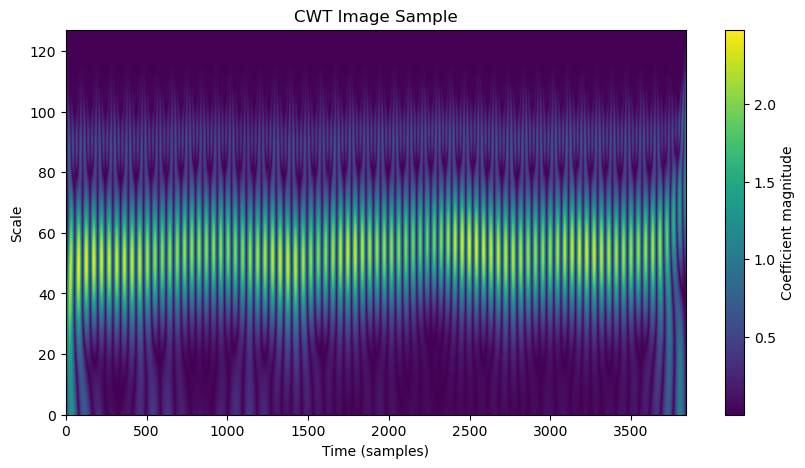

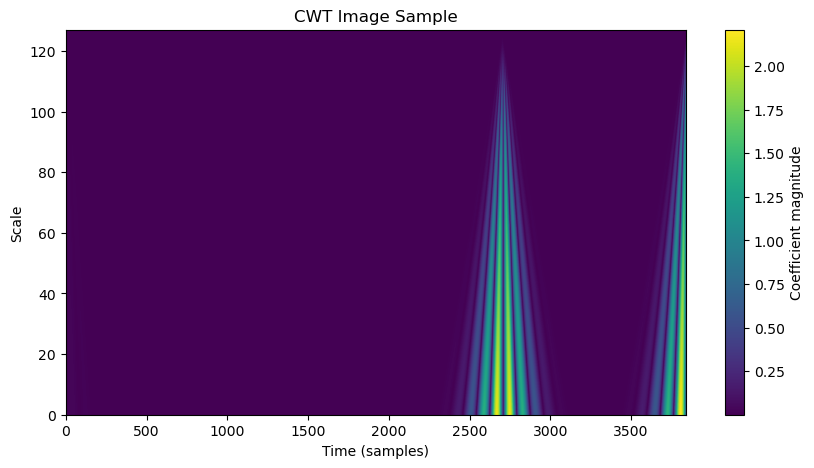

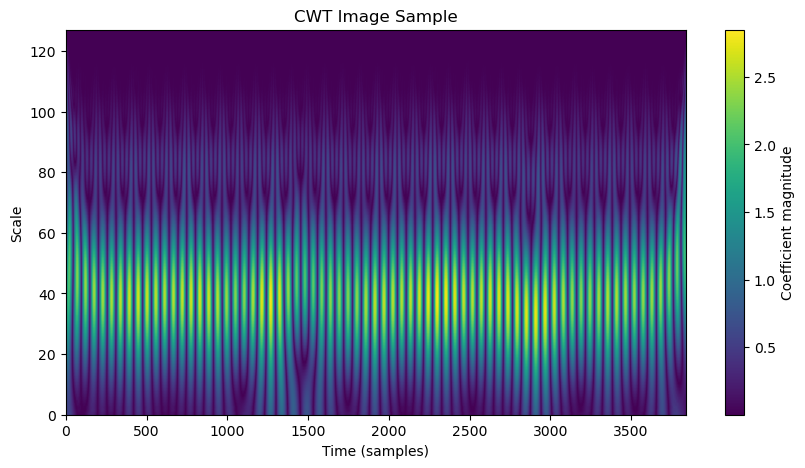

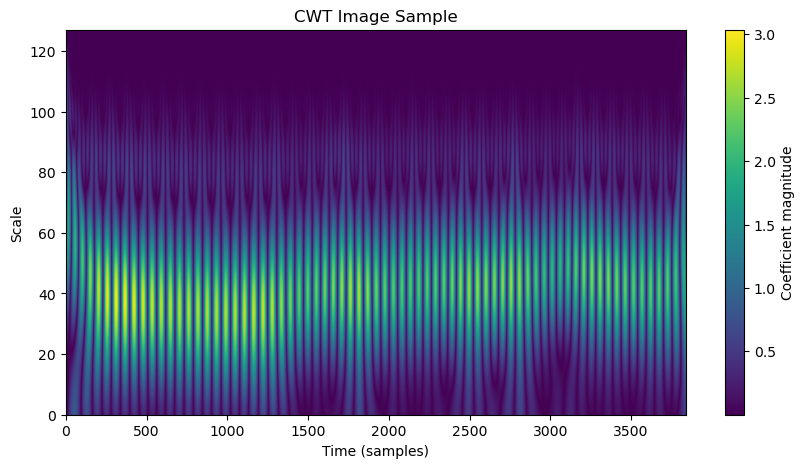

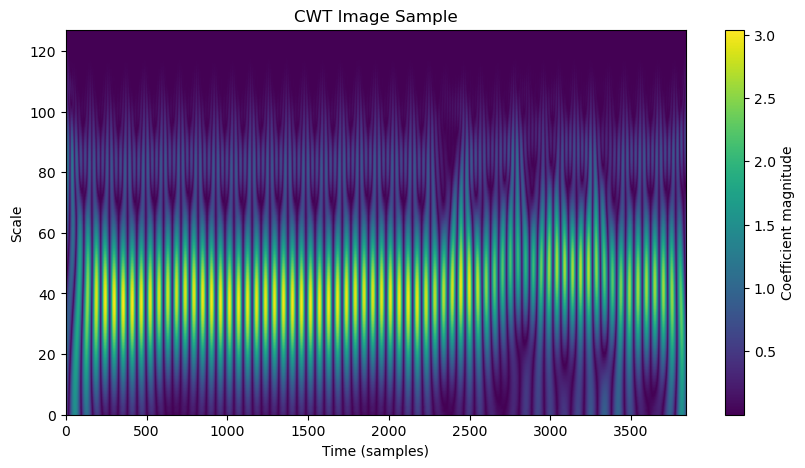

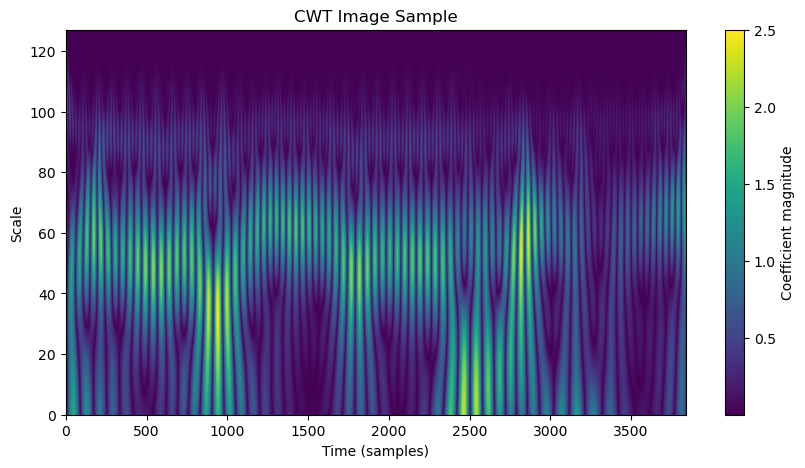

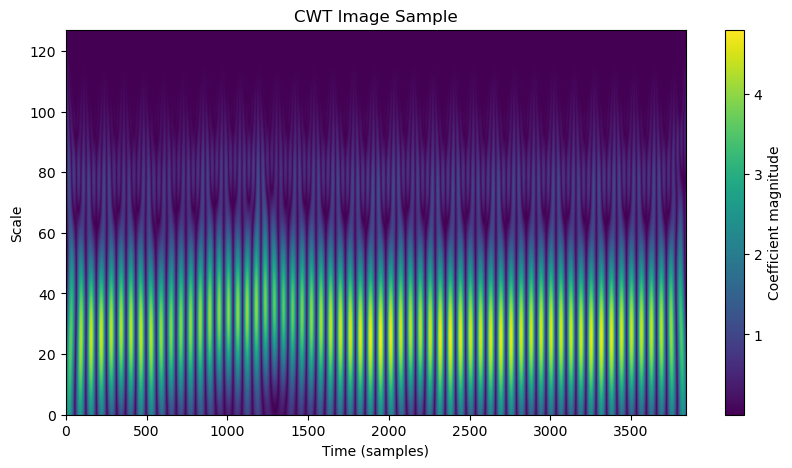

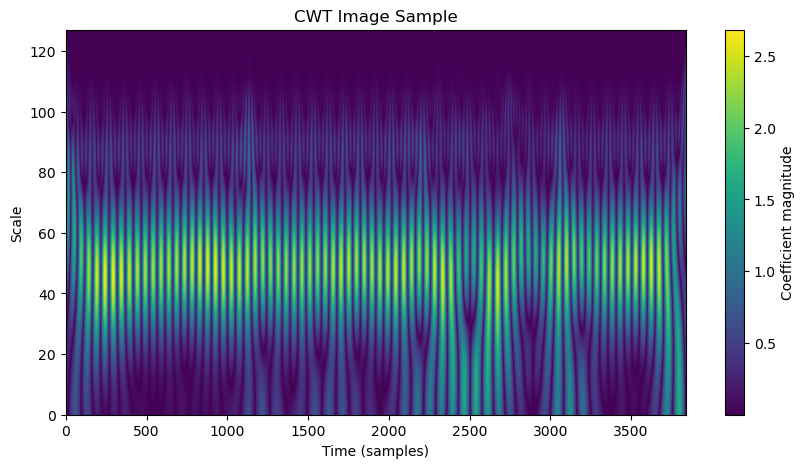

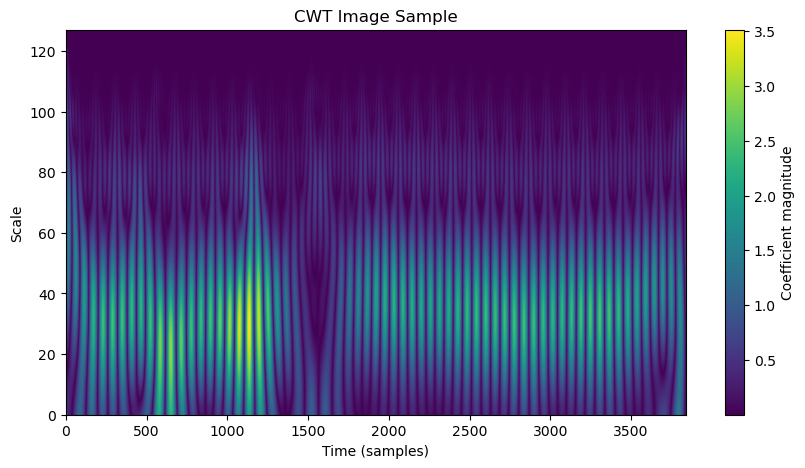

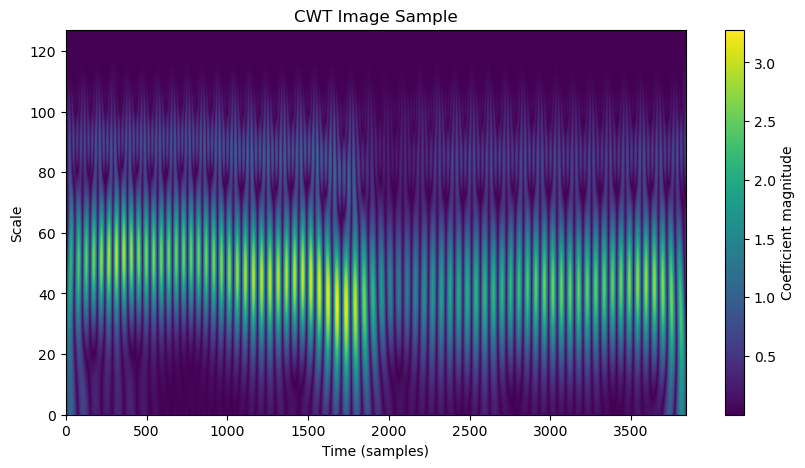

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import os
import pywt
import matplotlib.pyplot as plt

# Sampling rate
sampling_rate = 128  # Hz
epoch_duration = 30  # seconds
batch_size = sampling_rate * epoch_duration  # Number of samples per batch

# Function to load hypnogram (sleep stage labels) and PPG data
def load_data(hypno_file, pleth_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    pleth_data = np.loadtxt(pleth_file, skiprows=1)  # Skip the header line
    return hypno_data, pleth_data

# Function to segment PPG data into batches for 30-second epochs
def segment_batches(ppg_data, hypno_data):
    num_samples = len(ppg_data)
    num_batches = num_samples // batch_size
    data_batches = np.array_split(ppg_data[:num_batches * batch_size], num_batches)
    label_batches = np.array_split(hypno_data[:num_batches * batch_size], num_batches)
    return data_batches, label_batches

# Apply Continuous Wavelet Transform (CWT) and convert to images
def apply_cwt_and_convert_to_images(ppg_data):
    coefficients = []
    for signal in ppg_data:
        cwt_matrix, frequencies = pywt.cwt(signal, np.arange(1, 128), 'morl')
        coefficients.append(cwt_matrix)
    coefficients = np.array(coefficients)
    return coefficients

# File names
file_names = ['AHI11.2-1Hypno.txt', 'AHI11.2-1Pleth.txt',
              'AHI16.2-1Hypno.txt', 'AHI16.2-1Pleth.txt',
              'AHI17.3-1Hypno.txt', 'AHI17.3-1Pleth.txt', 
              'AHI18.4-1Hypno.txt', 'AHI18.4-1Pleth.txt',
              'AHI19.2-1Hypno.txt', 'AHI19.2-1Pleth.txt',
              'AHI20.8-1Hypno.txt', 'AHI20.8-1Pleth.txt',
              'AHI22.1-1Hypno.txt', 'AHI22.1-1Pleth.txt',
              'AHI28.3-1Hypno.txt', 'AHI28.3-1Pleth.txt',
              'AHI52.5-1Hypno.txt', 'AHI52.5-1Pleth.txt',
              'AHI68.7-1Hypno.txt', 'AHI68.7-1Pleth.txt']

def plot_representative_cwt_image(coefficients):
    # Choose a representative image (e.g., the first one)
    representative_image = coefficients[0]

    # Plot the image
    plt.figure(figsize=(10, 5))
    plt.imshow(np.abs(representative_image), aspect='auto', extent=[0, representative_image.shape[1], 0, representative_image.shape[0]])
    plt.title("CWT Image Sample")
    plt.xlabel("Time (samples)")
    plt.ylabel("Scale")
    plt.colorbar(label="Coefficient magnitude")
    plt.show()

# Process each subject's data
for i in range(0, len(file_names), 2):
    hypno_file = os.path.join('data', file_names[i])
    pleth_file = os.path.join('data', file_names[i + 1])
    subject_id = i // 2 + 1

    # Load data
    hypno_data, pleth_data = load_data(hypno_file, pleth_file)

    # Segment PPG data into batches
    ppg_batches, label_batches = segment_batches(pleth_data, hypno_data)
    

    # Apply CWT and convert to images
    coefficients = apply_cwt_and_convert_to_images(ppg_batches)

    # Print the resulting images
    print(plot_representative_cwt_image(coefficients))
        



 Wavelet Scattering using kymatio torch to get 2D images ~=500 images for each batches & each subjects

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
from kymatio.torch import Scattering1D  # Assuming you have installed kymatio library

# Sampling rate
sampling_rate = 128  # Hz
epoch_duration = 30  # seconds
batch_size = sampling_rate * epoch_duration  # Number of samples per batch

# Function to load hypnogram (sleep stage labels) and PPG data
def load_data(hypno_file, pleth_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    pleth_data = np.loadtxt(pleth_file, skiprows=1)  # Skip the header line
    return hypno_data, pleth_data

# Function to segment PPG data into batches for 30-second epochs
def segment_batches(ppg_data, hypno_data):
    num_samples = len(ppg_data)
    num_batches = num_samples // batch_size
    data_batches = np.array_split(ppg_data[:num_batches * batch_size], num_batches)
    label_batches = np.array_split(hypno_data[:num_batches * batch_size], num_batches)
    return data_batches, label_batches

# Function to apply Wavelet Scattering and convert to images
def apply_scattering_and_convert_to_images(ppg_data):
    scattering = Scattering1D(J=2, shape=(batch_size,))
    # Convert ppg_data to torch.Tensor with float32 data type
    ppg_tensor = torch.tensor(ppg_data, dtype=torch.float32)
    coefficients = scattering(ppg_tensor).cpu().numpy()
    return coefficients

# File names
file_names = ['AHI11.2-1Hypno.txt', 'AHI11.2-1Pleth.txt',
              'AHI16.2-1Hypno.txt', 'AHI16.2-1Pleth.txt',
              'AHI17.3-1Hypno.txt', 'AHI17.3-1Pleth.txt', 
              'AHI18.4-1Hypno.txt', 'AHI18.4-1Pleth.txt',
              'AHI19.2-1Hypno.txt', 'AHI19.2-1Pleth.txt',
              'AHI20.8-1Hypno.txt', 'AHI20.8-1Pleth.txt',
              'AHI22.1-1Hypno.txt', 'AHI22.1-1Pleth.txt',
              'AHI28.3-1Hypno.txt', 'AHI28.3-1Pleth.txt',
              'AHI52.5-1Hypno.txt', 'AHI52.5-1Pleth.txt',
              'AHI68.7-1Hypno.txt', 'AHI68.7-1Pleth.txt']

# Process each subject's data
for i in range(0, len(file_names), 2):
    hypno_file = os.path.join('data', file_names[i])
    pleth_file = os.path.join('data', file_names[i + 1])

    # Load data
    hypno_data, pleth_data = load_data(hypno_file, pleth_file)

    # Segment PPG data into batches
    ppg_batches, label_batches = segment_batches(pleth_data, hypno_data)

    # Apply Wavelet Scattering and convert to images for each batch
    coefficients = apply_scattering_and_convert_to_images(ppg_batches)

    # Plot scattering images for each batch
    num_batches = len(coefficients)
    for j in range(num_batches):
        plt.figure(figsize=(10, 5))
        plt.imshow(coefficients[j], aspect='auto', cmap='viridis')
        plt.title(f"Scattering Image for Batch {j+1}")
        plt.xlabel("Time (samples)")
        plt.ylabel("Scattering coefficient")
        plt.colorbar(label="Coefficient magnitude")
        plt.show()


C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_23084\1372821246.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  ppg_tensor = torch.tensor(ppg_data, dtype=torch.float32)


In [8]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
from kymatio.torch import Scattering1D  # Assuming you have installed kymatio library
from sklearn.model_selection import train_test_split

# Sampling rate
sampling_rate = 128  # Hz
epoch_duration = 30  # seconds
batch_size = sampling_rate * epoch_duration  # Number of samples per batch

# Function to load hypnogram (sleep stage labels) and PPG data
def load_data(hypno_file, pleth_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    pleth_data = np.loadtxt(pleth_file, skiprows=1)  # Skip the header line
    return hypno_data, pleth_data

# Function to segment PPG data into batches for 30-second epochs
def segment_batches(ppg_data, hypno_data):
    num_samples = len(ppg_data)
    num_batches = num_samples // batch_size
    data_batches = np.array_split(ppg_data[:num_batches * batch_size], num_batches)
    label_batches = np.array_split(hypno_data[:num_batches * batch_size], num_batches)
    return data_batches, label_batches

# Function to apply Wavelet Scattering and convert to images
def apply_scattering_and_convert_to_images(ppg_data):
    scattering = Scattering1D(J=2, shape=(batch_size,))
    # Convert ppg_data to torch.Tensor with float32 data type
    ppg_tensor = torch.tensor(ppg_data, dtype=torch.float32)
    coefficients = scattering(ppg_tensor).cpu().numpy()
    return coefficients

# File names
file_names = ['AHI11.2-1Hypno.txt', 'AHI11.2-1Pleth.txt',
              'AHI16.2-1Hypno.txt', 'AHI16.2-1Pleth.txt',
              'AHI17.3-1Hypno.txt', 'AHI17.3-1Pleth.txt', 
              'AHI18.4-1Hypno.txt', 'AHI18.4-1Pleth.txt',
              'AHI19.2-1Hypno.txt', 'AHI19.2-1Pleth.txt',
              'AHI20.8-1Hypno.txt', 'AHI20.8-1Pleth.txt',
              'AHI22.1-1Hypno.txt', 'AHI22.1-1Pleth.txt',
              'AHI28.3-1Hypno.txt', 'AHI28.3-1Pleth.txt',
              'AHI52.5-1Hypno.txt', 'AHI52.5-1Pleth.txt',
              'AHI68.7-1Hypno.txt', 'AHI68.7-1Pleth.txt']

# Initialize lists to store coefficients and labels
all_coefficients = []
all_labels = []

# Process each subject's data
for i in range(0, len(file_names), 2):
    hypno_file = os.path.join('data', file_names[i])
    pleth_file = os.path.join('data', file_names[i + 1])

    # Load data
    hypno_data, pleth_data = load_data(hypno_file, pleth_file)

    # Segment PPG data into batches
    ppg_batches, label_batches = segment_batches(pleth_data, hypno_data)

    # Apply Wavelet Scattering and convert to images for each batch
    coefficients = apply_scattering_and_convert_to_images(ppg_batches)

    # Concatenate coefficients and labels
    all_coefficients.extend(coefficients)
    all_labels.extend(label_batches)

# Convert lists to numpy arrays
all_coefficients = np.array(all_coefficients)
all_labels = np.array(all_labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_coefficients, all_labels, test_size=0.2, random_state=42)


# Reshape the labels to remove unnecessary dimensions
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

# Define data shape
data_shape = X_train[0].shape

# Display shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("Data shape:", data_shape)


C:\Users\LAB-502-04\AppData\Local\Temp\ipykernel_19816\2696975008.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  ppg_tensor = torch.tensor(ppg_data, dtype=torch.float32)


X_train shape: (7542, 4, 960)
X_test shape: (1886, 4, 960)
y_train shape: (7542,)
y_test shape: (1886,)
Data shape: (4, 960)


In [ ]:
#.....................................................................

In [7]:
from sklearn.preprocessing import OneHotEncoder

# Create a one-hot encoder
enc = OneHotEncoder(sparse=False)

# Encode labels
y_train_encoded = enc.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = enc.transform(y_test.reshape(-1, 1))


y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)



3 Stage Classification 10 epochs run!

In [23]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from kymatio.torch import Scattering1D
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Constants
sampling_rate = 128
epoch_duration = 30
batch_size = sampling_rate * epoch_duration

# Function to load data
def load_data(hypno_file, pleth_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    pleth_data = np.loadtxt(pleth_file, skiprows=1)
    return hypno_data, pleth_data

# Function to segment data into batches
def segment_batches(ppg_data, hypno_data):
    num_samples = len(ppg_data)
    num_batches = num_samples // batch_size
    data_batches = np.array_split(ppg_data[:num_batches * batch_size], num_batches)
    label_batches = np.array_split(hypno_data[:num_batches * batch_size], num_batches)
    return data_batches, label_batches

# Function to apply wavelet scattering and convert to images
def apply_scattering_and_convert_to_images(ppg_data):
    scattering = Scattering1D(J=2, shape=(batch_size,))
    ppg_tensor = torch.tensor(ppg_data, dtype=torch.float32)
    coefficients = scattering(ppg_tensor).cpu().numpy()
    return coefficients

# File names
file_names = ['AHI11.2-1Hypno.txt', 'AHI11.2-1Pleth.txt',
              'AHI16.2-1Hypno.txt', 'AHI16.2-1Pleth.txt',
              'AHI17.3-1Hypno.txt', 'AHI17.3-1Pleth.txt', 
              'AHI18.4-1Hypno.txt', 'AHI18.4-1Pleth.txt',
              'AHI19.2-1Hypno.txt', 'AHI19.2-1Pleth.txt',
              'AHI20.8-1Hypno.txt', 'AHI20.8-1Pleth.txt',
              'AHI22.1-1Hypno.txt', 'AHI22.1-1Pleth.txt',
              'AHI28.3-1Hypno.txt', 'AHI28.3-1Pleth.txt',
              'AHI52.5-1Hypno.txt', 'AHI52.5-1Pleth.txt',
              'AHI68.7-1Hypno.txt', 'AHI68.7-1Pleth.txt']

# Process each subject's data
all_coefficients = []
all_labels = []

for i in range(0, len(file_names), 2):
    hypno_file = os.path.join('data', file_names[i])
    pleth_file = os.path.join('data', file_names[i + 1])

    # Load data
    hypno_data, pleth_data = load_data(hypno_file, pleth_file)

    # Segment PPG data into batches
    ppg_batches, label_batches = segment_batches(pleth_data, hypno_data)

    # Apply Wavelet Scattering and convert to images for each batch
    coefficients = apply_scattering_and_convert_to_images(ppg_batches)

    # Concatenate coefficients and labels
    all_coefficients.extend(coefficients)
    all_labels.extend(label_batches)

# Convert lists to numpy arrays
all_coefficients = np.array(all_coefficients)
all_labels = np.array(all_labels)

# Map string labels to numerical values
label_to_num = {'W': 0, 'R': 1, 'N': 2, '1': 2, '2': 2, '3': 2, '4': 2}

# Convert all labels to numerical values
all_labels_numeric = []
for batch in all_labels:
    batch_numeric = [label_to_num[label] for label in batch.flatten()]
    all_labels_numeric.append(batch_numeric)
    
# Convert to numpy array
all_labels_numeric = np.array(all_labels_numeric)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_coefficients, all_labels_numeric, test_size=0.2, random_state=42)

# Define data shape
num_train_samples, num_time_steps, num_coeffs = X_train.shape
num_test_samples, _, _ = X_test.shape

# Define Vision Transformer model
class VisionTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=6, dropout=0.1):
        super(VisionTransformer, self).__init__()
        assert input_dim % num_heads == 0, "Input dimension must be divisible by the number of heads"

        self.transformer = nn.Transformer(
            d_model=input_dim, 
            nhead=num_heads, 
            num_encoder_layers=num_layers
        )
        self.fc = nn.Linear(input_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):

        tgt = torch.zeros_like(inputs)
        transformer_output = self.transformer(inputs, tgt=tgt)
        
        # Global average pooling over the sequence length
        pooled_output = transformer_output.mean(dim=1)
        
        # Apply dropout
        pooled_output = self.dropout(pooled_output)
        
        # Classification layer
        logits = self.fc(pooled_output)
        
        return logits

# Initialize model
model = VisionTransformer(input_dim=num_coeffs, num_classes=3)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Training
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)

        # Flatten the labels tensor
        labels_flat = labels.view(-1)

        loss = criterion(outputs, labels_flat)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels_flat.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    test_accuracy = correct / total


c:\Users\LAB-502-04\anaconda3\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Train Loss: 0.9520, Train Acc: 8.2290
Epoch [2/10], Train Loss: 0.9223, Train Acc: 8.5044
Epoch [3/10], Train Loss: 0.9213, Train Acc: 8.6509
Epoch [4/10], Train Loss: 0.9153, Train Acc: 8.7924
Epoch [5/10], Train Loss: 0.9142, Train Acc: 8.7615
Epoch [6/10], Train Loss: 0.9137, Train Acc: 8.7437
Epoch [7/10], Train Loss: 0.9138, Train Acc: 8.8199
Epoch [8/10], Train Loss: 0.9123, Train Acc: 8.8191
Epoch [9/10], Train Loss: 0.9127, Train Acc: 8.8194
Epoch [10/10], Train Loss: 0.9120, Train Acc: 8.8020


3 Stage Classification (W,R,N{1,2,3,4}) using wavelet-2D-ViT(Torchvision) for 25 epochs

In [24]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from kymatio.torch import Scattering1D
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Constants
sampling_rate = 128
epoch_duration = 30
batch_size = sampling_rate * epoch_duration

# Function to load data
def load_data(hypno_file, pleth_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    pleth_data = np.loadtxt(pleth_file, skiprows=1)
    return hypno_data, pleth_data

# Function to segment data into batches
def segment_batches(ppg_data, hypno_data):
    num_samples = len(ppg_data)
    num_batches = num_samples // batch_size
    data_batches = np.array_split(ppg_data[:num_batches * batch_size], num_batches)
    label_batches = np.array_split(hypno_data[:num_batches * batch_size], num_batches)
    return data_batches, label_batches

# Function to apply wavelet scattering and convert to images
def apply_scattering_and_convert_to_images(ppg_data):
    scattering = Scattering1D(J=2, shape=(batch_size,))
    ppg_tensor = torch.tensor(ppg_data, dtype=torch.float32)
    coefficients = scattering(ppg_tensor).cpu().numpy()
    return coefficients

# File names
file_names = ['AHI11.2-1Hypno.txt', 'AHI11.2-1Pleth.txt',
              'AHI16.2-1Hypno.txt', 'AHI16.2-1Pleth.txt',
              'AHI17.3-1Hypno.txt', 'AHI17.3-1Pleth.txt', 
              'AHI18.4-1Hypno.txt', 'AHI18.4-1Pleth.txt',
              'AHI19.2-1Hypno.txt', 'AHI19.2-1Pleth.txt',
              'AHI20.8-1Hypno.txt', 'AHI20.8-1Pleth.txt',
              'AHI22.1-1Hypno.txt', 'AHI22.1-1Pleth.txt',
              'AHI28.3-1Hypno.txt', 'AHI28.3-1Pleth.txt',
              'AHI52.5-1Hypno.txt', 'AHI52.5-1Pleth.txt',
              'AHI68.7-1Hypno.txt', 'AHI68.7-1Pleth.txt']

# Process each subject's data
all_coefficients = []
all_labels = []

for i in range(0, len(file_names), 2):
    hypno_file = os.path.join('data', file_names[i])
    pleth_file = os.path.join('data', file_names[i + 1])

    # Load data
    hypno_data, pleth_data = load_data(hypno_file, pleth_file)

    # Segment PPG data into batches
    ppg_batches, label_batches = segment_batches(pleth_data, hypno_data)

    # Apply Wavelet Scattering and convert to images for each batch
    coefficients = apply_scattering_and_convert_to_images(ppg_batches)

    # Concatenate coefficients and labels
    all_coefficients.extend(coefficients)
    all_labels.extend(label_batches)

# Convert lists to numpy arrays
all_coefficients = np.array(all_coefficients)
all_labels = np.array(all_labels)

# Map string labels to numerical values
label_to_num = {'W': 0, 'R': 1, 'N': 2, '1': 2, '2': 2, '3': 2, '4': 2}

# Convert all labels to numerical values
all_labels_numeric = []
for batch in all_labels:
    batch_numeric = [label_to_num[label] for label in batch.flatten()]
    all_labels_numeric.append(batch_numeric)
    
# Convert to numpy array
all_labels_numeric = np.array(all_labels_numeric)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_coefficients, all_labels_numeric, test_size=0.2, random_state=42)

# Define data shape
num_train_samples, num_time_steps, num_coeffs = X_train.shape
num_test_samples, _, _ = X_test.shape

# Define Vision Transformer model
class VisionTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=6, dropout=0.1):
        super(VisionTransformer, self).__init__()
        assert input_dim % num_heads == 0, "Input dimension must be divisible by the number of heads"

        self.transformer = nn.Transformer(
            d_model=input_dim, 
            nhead=num_heads, 
            num_encoder_layers=num_layers
        )
        self.fc = nn.Linear(input_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):

        tgt = torch.zeros_like(inputs)
        transformer_output = self.transformer(inputs, tgt=tgt)
        
        # Global average pooling over the sequence length
        pooled_output = transformer_output.mean(dim=1)
        
        # Apply dropout
        pooled_output = self.dropout(pooled_output)
        
        # Classification layer
        logits = self.fc(pooled_output)
        
        return logits

# Initialize model
model = VisionTransformer(input_dim=num_coeffs, num_classes=3)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Training
num_epochs = 25
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)

        # Flatten the labels tensor
        labels_flat = labels.view(-1)

        loss = criterion(outputs, labels_flat)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels_flat.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    test_accuracy = correct / total


c:\Users\LAB-502-04\anaconda3\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/25], Train Loss: 0.9628, Train Acc: 8.2845
Epoch [2/25], Train Loss: 0.9208, Train Acc: 8.6087
Epoch [3/25], Train Loss: 0.9218, Train Acc: 8.5558
Epoch [4/25], Train Loss: 0.9163, Train Acc: 8.7490
Epoch [5/25], Train Loss: 0.9134, Train Acc: 8.6978
Epoch [6/25], Train Loss: 0.9145, Train Acc: 8.7739
Epoch [7/25], Train Loss: 0.9150, Train Acc: 8.7498
Epoch [8/25], Train Loss: 0.9130, Train Acc: 8.8186
Epoch [9/25], Train Loss: 0.9125, Train Acc: 8.7526
Epoch [10/25], Train Loss: 0.9112, Train Acc: 8.7693
Epoch [11/25], Train Loss: 0.9126, Train Acc: 8.8290
Epoch [12/25], Train Loss: 0.9124, Train Acc: 8.7788
Epoch [13/25], Train Loss: 0.9106, Train Acc: 8.8100
Epoch [14/25], Train Loss: 0.9116, Train Acc: 8.8316
Epoch [15/25], Train Loss: 0.9113, Train Acc: 8.8276
Epoch [16/25], Train Loss: 0.9106, Train Acc: 8.8303
Epoch [17/25], Train Loss: 0.9104, Train Acc: 8.8263
Epoch [18/25], Train Loss: 0.9100, Train Acc: 8.8290
Epoch [19/25], Train Loss: 0.9110, Train Acc: 8.8263
Ep

# Confusion Matrix for 3 stage classification:

<Figure size 800x600 with 0 Axes>

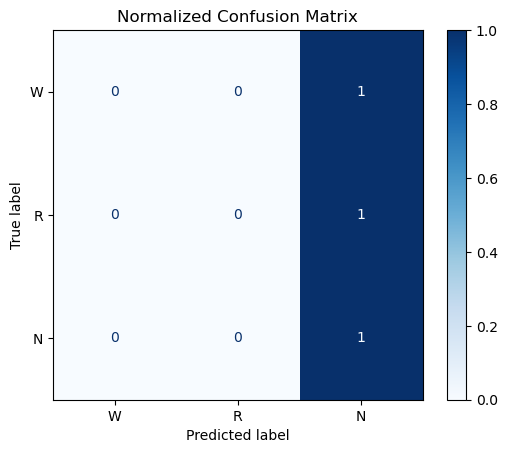

In [27]:
# Confusion Matrix for 3 stage classification:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())
        true_labels.extend(labels.numpy())


# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(cm_normalized, display_labels=['W', 'R', 'N'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.show()


Binary class sleep stage Classification (W,Sleep) 

In [57]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from kymatio.torch import Scattering1D
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Constants
sampling_rate = 128
epoch_duration = 30
batch_size = sampling_rate * epoch_duration

# Function to load data
def load_data(hypno_file, pleth_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    pleth_data = np.loadtxt(pleth_file, skiprows=1)
    return hypno_data, pleth_data

# Function to segment data into batches
def segment_batches(ppg_data, hypno_data):
    num_samples = len(ppg_data)
    num_batches = num_samples // batch_size
    data_batches = np.array_split(ppg_data[:num_batches * batch_size], num_batches)
    label_batches = np.array_split(hypno_data[:num_batches * batch_size], num_batches)
    return data_batches, label_batches

# Function to apply wavelet scattering and convert to images
def apply_scattering_and_convert_to_images(ppg_data):
    scattering = Scattering1D(J=2, shape=(batch_size,))
    ppg_tensor = torch.tensor(ppg_data, dtype=torch.float32)
    coefficients = scattering(ppg_tensor).cpu().numpy()
    return coefficients

# File names
file_names = ['AHI11.2-1Hypno.txt', 'AHI11.2-1Pleth.txt',
              'AHI16.2-1Hypno.txt', 'AHI16.2-1Pleth.txt',
              'AHI17.3-1Hypno.txt', 'AHI17.3-1Pleth.txt', 
              'AHI18.4-1Hypno.txt', 'AHI18.4-1Pleth.txt',
              'AHI19.2-1Hypno.txt', 'AHI19.2-1Pleth.txt',
              'AHI20.8-1Hypno.txt', 'AHI20.8-1Pleth.txt',
              'AHI22.1-1Hypno.txt', 'AHI22.1-1Pleth.txt',
              'AHI28.3-1Hypno.txt', 'AHI28.3-1Pleth.txt',
              'AHI52.5-1Hypno.txt', 'AHI52.5-1Pleth.txt',
              'AHI68.7-1Hypno.txt', 'AHI68.7-1Pleth.txt']

# Process each subject's data
all_coefficients = []
all_labels = []

for i in range(0, len(file_names), 2):
    hypno_file = os.path.join('data', file_names[i])
    pleth_file = os.path.join('data', file_names[i + 1])

    # Load data
    hypno_data, pleth_data = load_data(hypno_file, pleth_file)

    # Segment PPG data into batches
    ppg_batches, label_batches = segment_batches(pleth_data, hypno_data)

    # Apply Wavelet Scattering and convert to images for each batch
    coefficients = apply_scattering_and_convert_to_images(ppg_batches)

    # Concatenate coefficients and labels
    all_coefficients.extend(coefficients)
    all_labels.extend(label_batches)

# Convert lists to numpy arrays
all_coefficients = np.array(all_coefficients)
all_labels = np.array(all_labels)

# Map string labels to numerical values
label_to_num = {'W': 0, 'R': 1, '1': 1, '2': 1, '3': 1, '4': 1}

# Convert all labels to numerical values
all_labels_numeric = []
for batch in all_labels:
    batch_numeric = [label_to_num[label] for label in batch.flatten()]
    all_labels_numeric.append(batch_numeric)
    
# Convert to numpy array
all_labels_numeric = np.array(all_labels_numeric)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_coefficients, all_labels_numeric, test_size=0.2, random_state=42)

# Define data shape
num_train_samples, num_time_steps, num_coeffs = X_train.shape
num_test_samples, _, _ = X_test.shape

# Define Vision Transformer model for binary sleep classification
class VisionTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=6, dropout=0.1):
        super(VisionTransformer, self).__init__()
        assert input_dim % num_heads == 0, "Input dimension must be divisible by the number of heads"

        self.transformer = nn.Transformer(
            d_model=input_dim, 
            nhead=num_heads, 
            num_encoder_layers=num_layers
        )
        # Change the output dimension of the linear layer to match the number of classes (2 for binary sleep classification)
        self.fc = nn.Linear(input_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        tgt = torch.zeros_like(inputs)
        transformer_output = self.transformer(inputs, tgt=tgt)
        
        # Global average pooling over the sequence length
        pooled_output = transformer_output.mean(dim=1)
        
        # Apply dropout
        pooled_output = self.dropout(pooled_output)
        
        # Classification layer
        logits = self.fc(pooled_output)
        
        return logits

# Initialize model for binary sleep classification
num_classes = 2  # Wake and Sleep
model = VisionTransformer(input_dim=num_coeffs, num_classes=num_classes)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    # Stage 1 Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Flatten the labels tensor
        labels_flat = labels.view(-1)
        
        # Ensure outputs match the number of classes
        assert outputs.shape[1] == num_classes, f"Output shape mismatch. Expected {num_classes} classes."
        
        loss = criterion(outputs, labels_flat)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels_flat.size(0)  # Update the total count based on the flattened tensor
        correct += predicted.eq(labels_flat).sum().item()  # Compare with the flattened tensor

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    # Validation
    model.eval()
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in test_loader:
            val_outputs = model(val_inputs)
            val_labels_flat = val_labels.view(-1)
            val_loss = criterion(val_outputs, val_labels_flat)

            running_val_loss += val_loss.item()
            _, val_predicted = val_outputs.max(1)
            val_total += val_labels_flat.size(0)
            val_correct += val_predicted.eq(val_labels_flat).sum().item()

    val_loss = running_val_loss / len(test_loader)
    val_accuracy = val_correct / val_total

print(f'Epoch [{epoch+1}/{num_epochs}],  Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')


        





c:\Users\LAB-502-04\anaconda3\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


KeyboardInterrupt: 

In [54]:
print('Output shape:', outputs.shape)
print('Labels shape:', labels_flat.shape)

Output shape: torch.Size([16, 2])
Labels shape: torch.Size([16])


In [44]:
# Map string labels to numerical values for binary classification (Sleep and Wake)
label_to_num_binary = {'W': 0, 'S': 1, 'R': 1, '1': 1, '2': 1, '3': 1, '4': 1}

# Convert all labels to numerical values for binary classification
all_labels_numeric_binary = []
for batch in all_labels:
    batch_numeric = [label_to_num_binary[label] for label in batch.flatten()]
    all_labels_numeric_binary.append(batch_numeric)

# Convert to numpy array for binary classification
all_labels_numeric_binary = np.array(all_labels_numeric_binary)

# Split data into training and testing sets for binary classification
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(all_coefficients, all_labels_numeric_binary, test_size=0.2, random_state=42)

# Define Vision Transformer model for binary classification
class VisionTransformerBinary(nn.Module):
    def __init__(self, input_dim, num_classes=2, num_heads=8, num_layers=6, dropout=0.1):
        super(VisionTransformerBinary, self).__init__()
        assert input_dim % num_heads == 0, "Input dimension must be divisible by the number of heads"

        self.transformer = nn.Transformer(
            d_model=input_dim, 
            nhead=num_heads, 
            num_encoder_layers=num_layers
        )
        self.fc = nn.Linear(input_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        tgt = torch.zeros_like(inputs)
        transformer_output = self.transformer(inputs, tgt=tgt)
        
        # Global average pooling over the sequence length
        pooled_output = transformer_output.mean(dim=1)
        
        # Apply dropout
        pooled_output = self.dropout(pooled_output)
        
        # Classification layer
        logits = self.fc(pooled_output)
        
        return logits

# Initialize model for binary classification
binary_classifier_model = VisionTransformerBinary(input_dim=num_coeffs, num_classes=2)

# Define optimizer and loss function for binary classification
optimizer_binary = optim.Adam(binary_classifier_model.parameters(), lr=1e-4)
criterion_binary = nn.CrossEntropyLoss()

# Convert data to tensors for binary classification
X_train_tensor_binary = torch.tensor(X_train_binary, dtype=torch.float32)
X_test_tensor_binary = torch.tensor(X_test_binary, dtype=torch.float32)
y_train_tensor_binary = torch.tensor(y_train_binary, dtype=torch.long)
y_test_tensor_binary = torch.tensor(y_test_binary, dtype=torch.long)

# Create DataLoader for binary classification
train_dataset_binary = torch.utils.data.TensorDataset(X_train_tensor_binary, y_train_tensor_binary)
test_dataset_binary = torch.utils.data.TensorDataset(X_test_tensor_binary, y_test_tensor_binary)
train_loader_binary = DataLoader(train_dataset_binary, batch_size=16, shuffle=True)
test_loader_binary = DataLoader(test_dataset_binary, batch_size=16, shuffle=False)

# Training for binary classification
num_epochs_binary = 30
binary_classifier_model.train()
for epoch in range(num_epochs_binary):
    running_loss_binary = 0.0
    correct_binary = 0
    total_binary = 0
    for inputs_binary, labels_binary in train_loader_binary:
        optimizer_binary.zero_grad()
        outputs_binary = binary_classifier_model(inputs_binary)
        
        # Flatten the labels tensor
        labels_flat_binary = labels_binary.view(-1)
        
        loss_binary = criterion_binary(outputs_binary, labels_flat_binary)
        loss_binary.backward()
        optimizer_binary.step()

        running_loss_binary += loss_binary.item()
        _, predicted_binary = outputs_binary.max(1)
        total_binary += labels_flat_binary.size(0)  # Update total with the size of flattened labels
        correct_binary += predicted_binary.eq(labels_flat_binary).sum().item()

    train_loss_binary = running_loss_binary / len(train_loader_binary)
    train_accuracy_binary = correct_binary / total_binary

    print(f'Epoch [{epoch+1}/{num_epochs_binary}], Train Loss: {train_loss_binary:.4f}, Train Acc: {train_accuracy_binary:.4f}')


# Evaluation for binary classification
binary_classifier_model.eval()
with torch.no_grad():
    correct_binary = 0
    total_binary = 0
    for inputs_binary, labels_binary in test_loader_binary:
        outputs_binary = binary_classifier_model(inputs_binary)
        _, predicted_binary = outputs_binary.max(1)
        total_binary += labels_binary.size(0)
        correct_binary += predicted_binary.eq(labels_binary).sum().item()

    test_accuracy_binary = correct_binary / total_binary


Epoch [1/30], Train Loss: 0.6980, Train Acc: 0.6128
Epoch [2/30], Train Loss: 0.6683, Train Acc: 0.6248
Epoch [3/30], Train Loss: 0.6611, Train Acc: 0.6378
Epoch [4/30], Train Loss: 0.6602, Train Acc: 0.6374
Epoch [5/30], Train Loss: 0.6608, Train Acc: 0.6346
Epoch [6/30], Train Loss: 0.6610, Train Acc: 0.6374
Epoch [7/30], Train Loss: 0.6585, Train Acc: 0.6380
Epoch [8/30], Train Loss: 0.6582, Train Acc: 0.6380
Epoch [9/30], Train Loss: 0.6584, Train Acc: 0.6383
Epoch [10/30], Train Loss: 0.6586, Train Acc: 0.6380
Epoch [11/30], Train Loss: 0.6571, Train Acc: 0.6380
Epoch [12/30], Train Loss: 0.6570, Train Acc: 0.6380
Epoch [13/30], Train Loss: 0.6565, Train Acc: 0.6380
Epoch [14/30], Train Loss: 0.6566, Train Acc: 0.6380
Epoch [15/30], Train Loss: 0.6564, Train Acc: 0.6380
Epoch [16/30], Train Loss: 0.6579, Train Acc: 0.6380
Epoch [17/30], Train Loss: 0.6562, Train Acc: 0.6380
Epoch [18/30], Train Loss: 0.6567, Train Acc: 0.6380
Epoch [19/30], Train Loss: 0.6562, Train Acc: 0.6380
Ep

4 Class Sleep Stage classification>> wake, light sleep(1,2), deep sleep(3,4),REM

In [66]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from kymatio.torch import Scattering1D
import torch.nn.functional as F


# Constants
sampling_rate = 128
epoch_duration = 30
batch_size = sampling_rate * epoch_duration

# Function to load data
def load_data(hypno_file, pleth_file):
    hypno_data = pd.read_csv(hypno_file, header=None, names=['Label'])
    pleth_data = np.loadtxt(pleth_file, skiprows=1)
    return hypno_data, pleth_data

# Function to segment data into batches
def segment_batches(ppg_data, hypno_data):
    num_samples = len(ppg_data)
    num_batches = num_samples // batch_size
    data_batches = np.array_split(ppg_data[:num_batches * batch_size], num_batches)
    label_batches = np.array_split(hypno_data[:num_batches * batch_size], num_batches)
    return data_batches, label_batches

# Function to apply wavelet scattering and convert to images
def apply_scattering_and_convert_to_images(ppg_data):
    scattering = Scattering1D(J=2, shape=(batch_size,))
    ppg_tensor = torch.tensor(ppg_data, dtype=torch.float32)
    coefficients = scattering(ppg_tensor).cpu().numpy()
    return coefficients

# File names
file_names = ['AHI11.2-1Hypno.txt', 'AHI11.2-1Pleth.txt',
              'AHI16.2-1Hypno.txt', 'AHI16.2-1Pleth.txt',
              'AHI17.3-1Hypno.txt', 'AHI17.3-1Pleth.txt', 
              'AHI18.4-1Hypno.txt', 'AHI18.4-1Pleth.txt',
              'AHI19.2-1Hypno.txt', 'AHI19.2-1Pleth.txt',
              'AHI20.8-1Hypno.txt', 'AHI20.8-1Pleth.txt',
              'AHI22.1-1Hypno.txt', 'AHI22.1-1Pleth.txt',
              'AHI28.3-1Hypno.txt', 'AHI28.3-1Pleth.txt',
              'AHI52.5-1Hypno.txt', 'AHI52.5-1Pleth.txt',
              'AHI68.7-1Hypno.txt', 'AHI68.7-1Pleth.txt']

# Process each subject's data
all_coefficients = []
all_labels = []

for i in range(0, len(file_names), 2):
    hypno_file = os.path.join('data', file_names[i])
    pleth_file = os.path.join('data', file_names[i + 1])

    # Load data
    hypno_data, pleth_data = load_data(hypno_file, pleth_file)

    # Segment PPG data into batches
    ppg_batches, label_batches = segment_batches(pleth_data, hypno_data)

    # Apply Wavelet Scattering and convert to images for each batch
    coefficients = apply_scattering_and_convert_to_images(ppg_batches)

    # Concatenate coefficients and labels
    all_coefficients.extend(coefficients)
    all_labels.extend(label_batches)

# Convert lists to numpy arrays
all_coefficients = np.array(all_coefficients)
all_labels = np.array(all_labels)

# Map string labels to numerical values
label_to_num = {'W': 0, 'R': 1, 'N': 2, '1': 2, '2': 2, '3': 3, '4': 3}
 

# Convert all labels to numerical values
all_labels_numeric = []
for batch in all_labels:
    batch_numeric = [label_to_num[label] for label in batch.flatten()]
    all_labels_numeric.append(batch_numeric)
    
# Convert to numpy array
all_labels_numeric = np.array(all_labels_numeric)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_coefficients, all_labels_numeric, test_size=0.2, random_state=42)

# Define data shape
num_train_samples, num_time_steps, num_coeffs = X_train.shape
num_test_samples, _, _ = X_test.shape

# Define Vision Transformer model
class VisionTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=6, dropout=0.1):
        super(VisionTransformer, self).__init__()
        assert input_dim % num_heads == 0, "Input dimension must be divisible by the number of heads"

        self.transformer = nn.Transformer(
            d_model=input_dim, 
            nhead=num_heads, 
            num_encoder_layers=num_layers
        )
        self.fc = nn.Linear(input_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):

        tgt = torch.zeros_like(inputs)
        transformer_output = self.transformer(inputs, tgt=tgt)
        
        # Global average pooling over the sequence length
        pooled_output = transformer_output.mean(dim=1)
        
        # Apply dropout
        pooled_output = self.dropout(pooled_output)
        
        # Classification layer
        logits = self.fc(pooled_output)
        
        return logits

# Initialize model
model = VisionTransformer(input_dim=num_coeffs, num_classes=4)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Training
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)

        # Flatten the labels tensor
        labels_flat = labels.view(-1)

        loss = criterion(outputs, labels_flat)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels_flat.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    test_accuracy = correct / total


c:\Users\LAB-502-04\anaconda3\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Train Loss: 1.2923, Train Acc: 6.0171
Epoch [2/10], Train Loss: 1.2571, Train Acc: 6.0786
Epoch [3/10], Train Loss: 1.2536, Train Acc: 6.1234
Epoch [4/10], Train Loss: 1.2462, Train Acc: 6.1883
Epoch [5/10], Train Loss: 1.2420, Train Acc: 6.1352
Epoch [6/10], Train Loss: 1.2410, Train Acc: 6.2084
Epoch [7/10], Train Loss: 1.2448, Train Acc: 6.2034
Epoch [8/10], Train Loss: 1.2415, Train Acc: 6.1667


KeyboardInterrupt: 